In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from utils01 import GROParser

In [2]:
cb_mode = False
# cb_mode = True

In [3]:
gro = "input/solv_ions_prot.gro"
# gro = "input/topo.gro"
CUTOFF_RADIUS = 1.0

groparser = GROParser(gro, CUTOFF_RADIUS, cb_mode)
MAINCHAIN = groparser.mainchains
N_ATOMS = groparser.n_atoms
EACH_N_ATOMS = groparser.each_n_atoms
SLICE_INDECES = groparser.slice_indeces
ARRANGED_INDECES = groparser.arranged_indeces
REARRANGED_INDECES = groparser.rearranged_indeces
ADJACENT_INDECES = groparser.adjacent_indeces
AB_INDECES = groparser.ab_indeces
ATOM_ALIGN = groparser.atom_align
TARGET_ATOM_INDECES_FOR_XVG = groparser.target_atom_indeces_for_xvg

In [4]:
N_BINS = 20

# read trj

In [5]:
filepath = "input/xvg/run2/Protein-coord.xvg"
# filepath = "input/run1/MainChain-coord.xvg"
# filepath = "input/2fs/MainChain-coord.xvg"

acttrj = pd.read_csv(filepath, comment='@', delimiter='\t',
                            header=None, skiprows=14).values[:, 1:]
acttrj = acttrj.reshape(acttrj.shape[0], -1, 3)[:, TARGET_ATOM_INDECES_FOR_XVG, :]
acttrj = acttrj[:, ARRANGED_INDECES, :]
acttrj.shape

(201, 1236, 3)

In [6]:
acttrj = acttrj[100:200]
# acttrj = acttrj[200:300]
# acttrj = acttrj[:499]

In [7]:
# filepath = "workspace/04-simulate/test25.npy"
# filepath = "remote-workspace/04-simulate/test25.npy"
# filepath = "remote-workspace/04-simulate/test28.npy"
filepath = "remote-workspace/04-simulate/test40.npy"
prdtrj = np.load(filepath)
prdtrj = prdtrj[:, ARRANGED_INDECES, :]
prdtrj.shape

(499, 1236, 3)

In [8]:
# prdtrj = prdtrj[200:300]
prdtrj = prdtrj[100:200]
# prdtrj = prdtrj[:100]

In [9]:
# prdtrj = acttrj

In [10]:
label1 = "Gromacs"
label2 = "Simplified"

# RDF

In [11]:
def cal_rdf(trj, species, residues, cutoff=CUTOFF_RADIUS, n_bins=100):
    all_distances = []
    for residue in residues:
        i, j = SLICE_INDECES[species[0]]
        center_coords = trj[:, i:j, :]
        center_coords = center_coords[:, residue, :]

        i, j = SLICE_INDECES[species[1]]
        nearby_coords = trj[:, i:j, :]
        
        center_coords = np.tile(center_coords, nearby_coords.shape[1]).reshape(center_coords.shape[0], -1, 3)

        distances = np.sqrt(np.sum(np.square(np.subtract(nearby_coords, center_coords)), axis=2)).flatten()
        distances = distances[distances<=cutoff]
        all_distances.extend(distances.tolist())
    
    hist, bins = np.histogram(all_distances, bins=n_bins)
    dr = bins[1] - bins[0]
    rho = 1
    rdf = hist/(4*np.pi*np.power(bins[:-1],2)*dr*rho)
    return bins[:-1], rdf

In [12]:
species_list = [
    ['CA', 'N'],
    ['CA', 'C'],
    ['N', 'C'],
    ['C', 'O'],
    ['CA', 'O'],
    ['N', 'O'],
]

In [13]:
def plot_rdf(trj):
    fig = plt.figure(figsize=(10,4*len(species_list)))

    for i, species in enumerate(species_list):
        residues = range(EACH_N_ATOMS[species[0]])
        radiuses, rdf = cal_rdf(trj, species, residues)

        fig.add_subplot(len(species_list), 1, i+1)

        plt.plot(radiuses, rdf)
        plt.scatter(radiuses, rdf)
        
        plt.xlabel("radius (nm)")
        plt.ylabel("RDF like")

        plt.xlabel("radius (nm)", fontsize=14)
        plt.ylabel("kind of RDF", fontsize=14)

        plt.title(f"{species[0]}-{species[1]} (peak: {radiuses[np.argmax(rdf)]:.2f})", fontsize=14)
        plt.xlim(0, CUTOFF_RADIUS)
        plt.tight_layout()

In [14]:
def plot_rdf_double(trj1, trj2, label1, label2):
    fig = plt.figure(figsize=(10,4*len(species_list)))

    for i, species in enumerate(species_list):
        residues = range(EACH_N_ATOMS[species[0]])
        radiuses1, rdf1 = cal_rdf(trj1, species, residues)
        radiuses2, rdf2 = cal_rdf(trj2, species, residues)

        fig.add_subplot(len(species_list), 1, i+1)

        plt.plot(radiuses1, rdf1, label=label1)
        plt.plot(radiuses2, rdf2, label=label2)

        plt.title(f"{species[0]}-{species[1]}", fontsize=14)
        
        plt.xlabel("radius (nm)", fontsize=14)
        plt.ylabel("kind of RDF", fontsize=14)
        
        plt.legend()
        plt.tight_layout()

In [15]:
def plot_each_peak(trj):
    fig = plt.figure(figsize=(10,4*len(species_list)))

    for i, species in enumerate(species_list):
        residues = range(EACH_N_ATOMS[species[0]])
        
        radiuses_rdfs = [cal_rdf(trj[[t], :, :], species, residues) for t in range(trj.shape[0])]
        peaks = [radiuses[np.argmax(rdf)] for radiuses, rdf in radiuses_rdfs]

        fig.add_subplot(len(species_list), 1, i+1)

        plt.plot(list(range(trj.shape[0])), peaks)
        plt.scatter(list(range(trj.shape[0])), peaks)

        plt.title(f"{species[0]}-{species[1]}", fontsize=14)
        plt.tight_layout()

## actual

### whole time

In [16]:
# plot_rdf(acttrj)

### peak each time

In [17]:
# plot_each_peak(acttrj)

## pred

### whole time

In [18]:
# plot_rdf(prdtrj)

In [19]:
# plot_each_peak(prdtrj)

## act-pred-wholetime

In [20]:
# plot_rdf_double(acttrj, prdtrj, "Gromacs", "Simplified")

# 隣の原子との距離

In [21]:
approved_species = {
    'CA-N': [0, 0],
    'CA-C': [1, 0],
    'N-C': [0, 1],
    'N-CA': [1, 0],
    'C-CA': [0, 0],
    'C-O': [1, 0],
    'C-N': [1, 1],
    'O-C': [0, 0]
}

In [22]:
# def cal_radius_list(trj, center_species, species2):
#     l, u = SLICE_INDECES[center_species]
#     radiuses = []
#     for i in range(l, u):
#         center_coords = trj[:, i, :]

#         try:
#             x,y = approved_species[f"{center_species}-{species2}"]
#             coords2 = trj[:, ADJACENT_INDECES[i][x][y], :]
#         except IndexError:
#             continue
        
#         radiuses.extend(np.sqrt(np.sum(np.square(np.subtract(coords2, center_coords)), axis=1)).flatten().tolist())
    
#     return radiuses

def cal_radius_arr(trj, center_species, species2):
    l, u = SLICE_INDECES[center_species]
    radiuses = []
    for i in range(l, u):
        center_coords = trj[:, i, :]

        try:
            x,y = approved_species[f"{center_species}-{species2}"]
            coords2 = trj[:, ADJACENT_INDECES[i][x][y], :]
        except IndexError:
            continue
        
        radiuses.append(np.sqrt(np.sum(np.square(np.subtract(coords2, center_coords)), axis=1)))
    
    return np.array(radiuses).transpose(1, 0)

In [23]:
species_list = [
    ['CA', 'N'], ['CA', 'C'], ['N', 'C'], ['C', 'O'], ['C', 'N']
]

N_FIGS =len(species_list)

In [24]:
def plot_radiuses_hist(trj):
    fig = plt.figure(figsize=(20,5*N_FIGS))

    i = 0
    for species_center, species2 in species_list:
        i += 1
        fig.add_subplot(N_FIGS, 1, i)

        radius_list = cal_radius_list(trj, species_center, species2)
        hist, bins = np.histogram(radius_list, bins=N_BINS)

        plt.bar([f"{round((bins[i]+bins[i+1])/2, 1)}" for i in range(len(hist))], hist)

        plt.xlabel("radius (nm)", fontsize=14)
        plt.ylabel("Frequency", fontsize=14)

        plt.title(f"{species_center}-{species2} (mean: {np.mean(radius_list)})", fontsize=14)
    plt.tight_layout()

In [25]:
def double_plot_radiuses_hist(trj1, trj2):
    fig = plt.figure(figsize=(20,5*N_FIGS*2))

    i = 0
    for species_center, species2 in species_list:
        radius_arr1 = cal_radius_arr(trj1, species_center, species2)
        radius_arr2 = cal_radius_arr(trj2, species_center, species2)
        
        radius_list1 = radius_arr1.flatten().tolist()
        radius_list2 = radius_arr2.flatten().tolist()
        
        binmax = max(radius_list1 + radius_list2)
        binmin = min(radius_list1 + radius_list2)

        # bar1
        i += 1
        fig.add_subplot(N_FIGS*2, 1, i)
        
        hist, bins = np.histogram(radius_list1, range=(binmin, binmax), bins=N_BINS)
        
        plt.bar([f"{round((bins[i]+bins[i+1])/2, 3)}" for i in range(len(hist))], hist)

        plt.xlabel("radius (nm)", fontsize=14)
        plt.ylabel("Frequency", fontsize=14)

        plt.title(f"{species_center}-{species2} (mean: {np.mean(radius_list1)}, std: {np.std(radius_list1)})", fontsize=14)
        
        # bar2
        i += 1
        fig.add_subplot(N_FIGS*2, 1, i)

        hist, bins = np.histogram(radius_list1, range=(binmin, binmax), bins=N_BINS)
        
        plt.bar([f"{round((bins[i]+bins[i+1])/2, 3)}" for i in range(len(hist))], hist, color="#ff7f00")

        plt.xlabel("radius (nm)", fontsize=14)
        plt.ylabel("Frequency", fontsize=14)

        plt.title(f"{species_center}-{species2} (mean: {np.mean(radius_list2)}, std: {np.std(radius_list2)})", fontsize=14)

    plt.tight_layout()

## hist

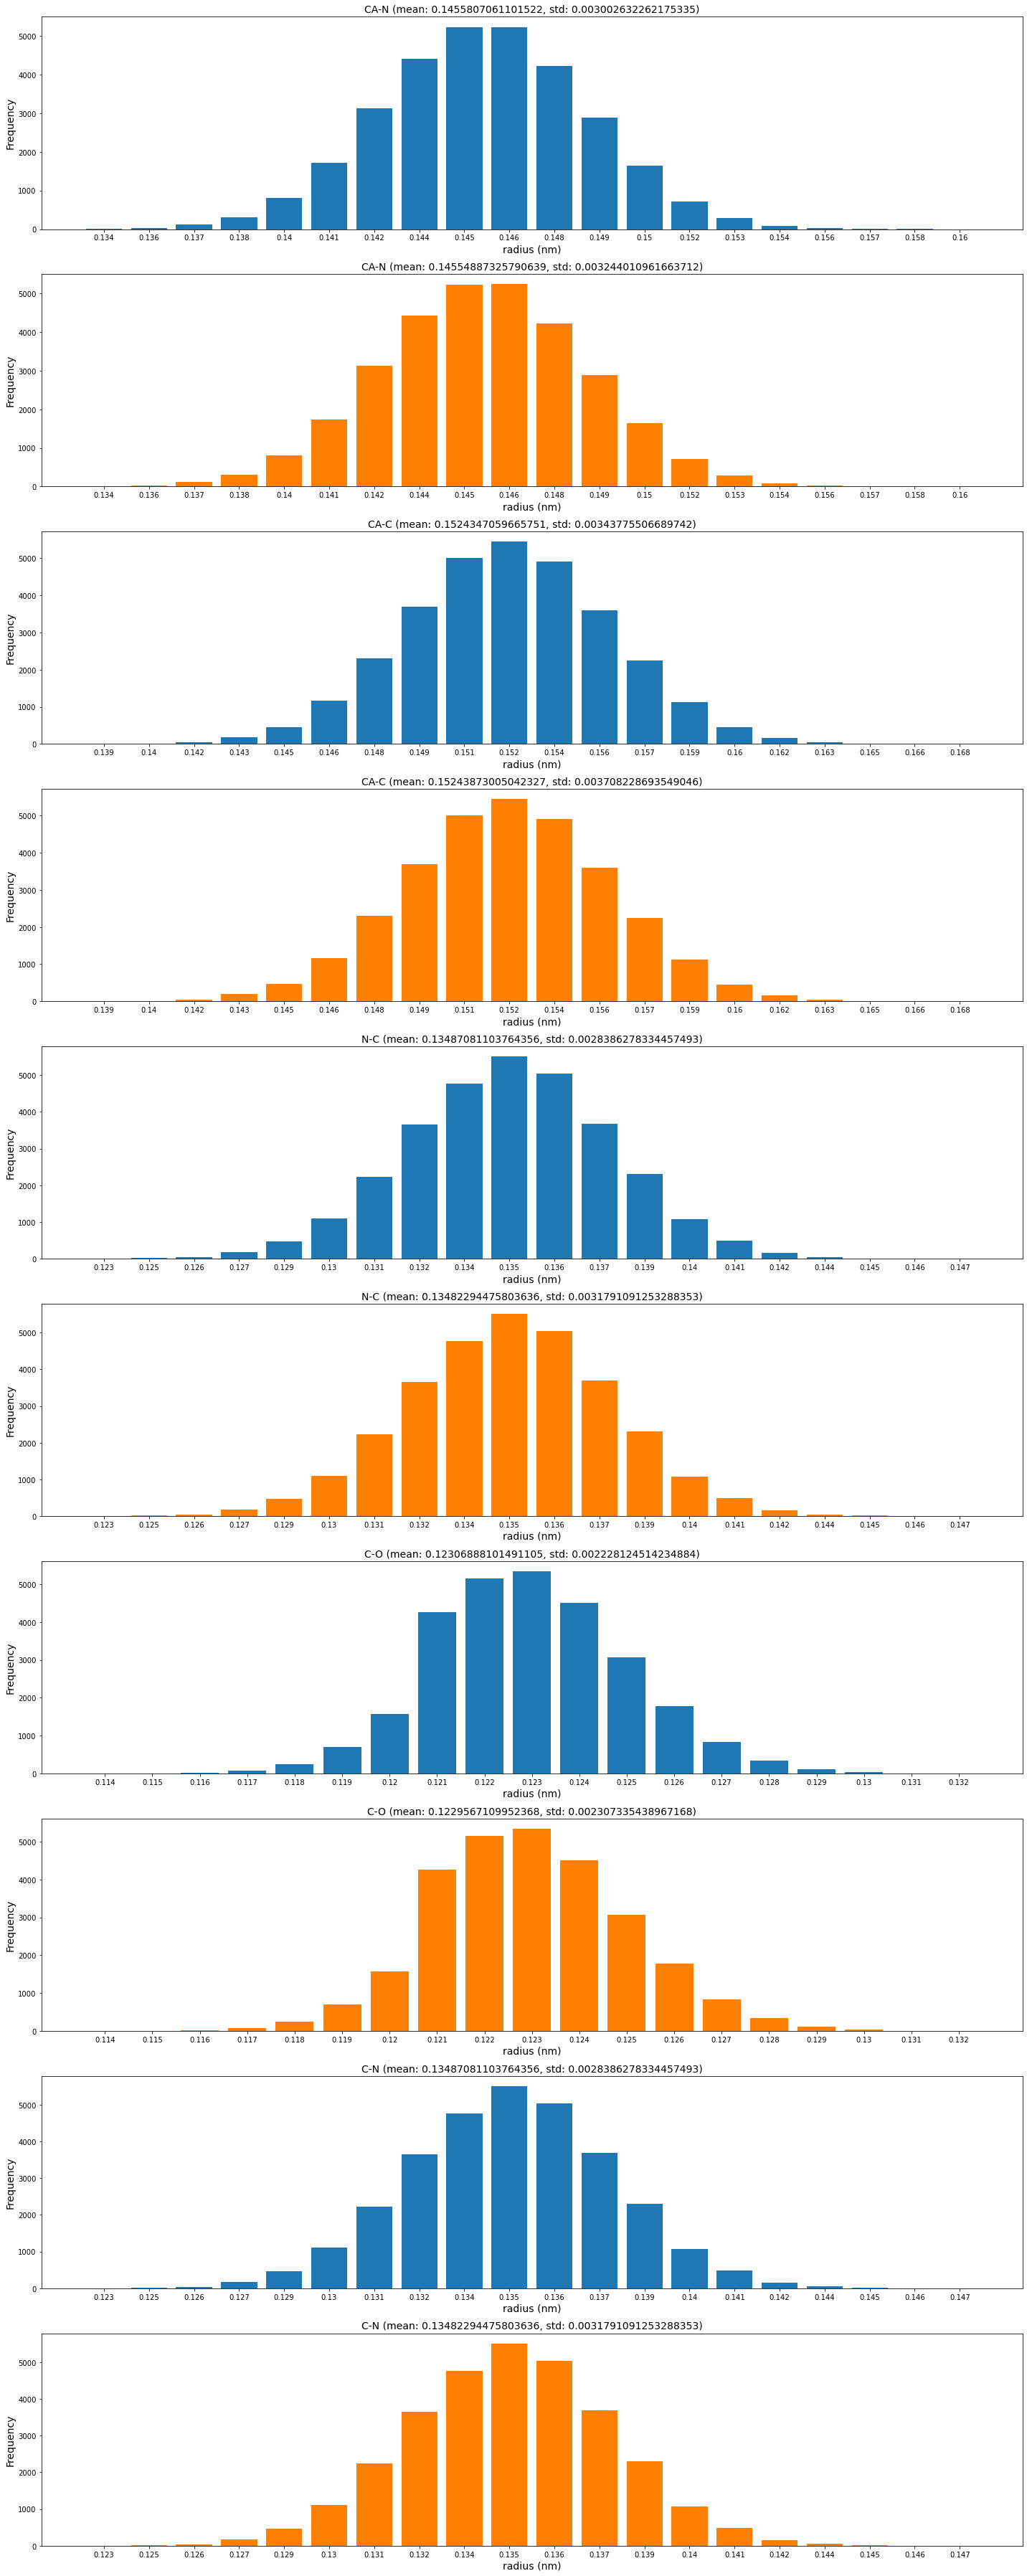

In [26]:
double_plot_radiuses_hist(acttrj, prdtrj)

## each time

In [27]:
def plot_each_radius(trj1, trj2, label1, label2, sp1, sp2, meanstd="mean", axis=1):
    plt.rcParams["font.size"] = 18
    fig = plt.figure(figsize=(20,5))
    fig.add_subplot(1, 1, 1)

    if meanstd == "mean":
        degree_list1 = cal_radius_arr(trj1, sp1, sp2).mean(axis=axis).tolist()
        degree_list2 = cal_radius_arr(trj2, sp1, sp2).mean(axis=axis).tolist()
    elif meanstd == "std":
        degree_list1 = cal_radius_arr(trj1, sp1, sp2).std(axis=axis).tolist()
        degree_list2 = cal_radius_arr(trj2, sp1, sp2).std(axis=axis).tolist()
    
    print(np.argmax(degree_list2))

    plt.plot(list(range(len(degree_list1))), degree_list1, label=label1)
    plt.plot(list(range(len(degree_list2))), degree_list2, label=label2)
    plt.tight_layout()
    
    plt.title(f"{sp1}-{sp2}")
    
    if axis==0:
        plt.xlabel("residue number")
    plt.ylabel("bond length (nm)")

    plt.legend()

In [28]:
axis = 1

### mean

In [29]:
meanstd = "mean"

71


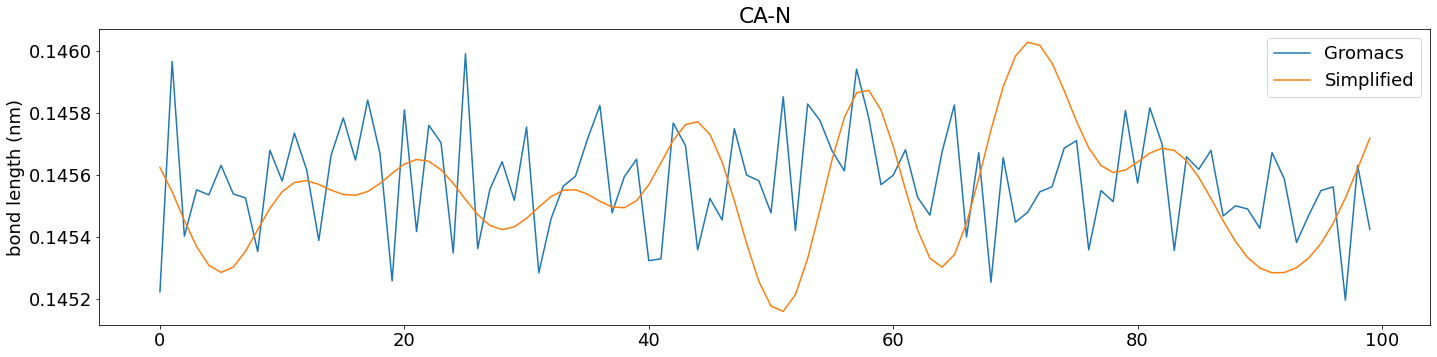

In [30]:
plot_each_radius(acttrj, prdtrj, label1, label2, 'CA', 'N', meanstd=meanstd, axis=axis)

79


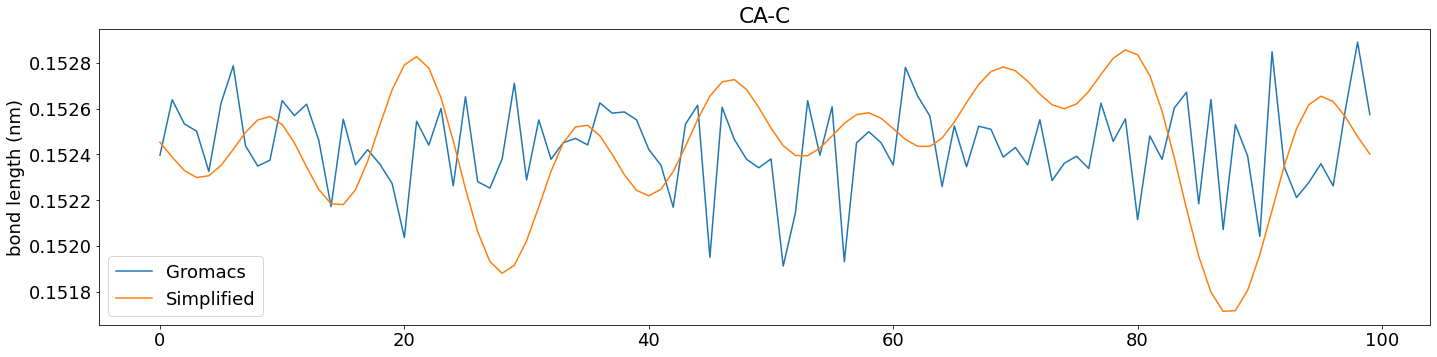

In [31]:
plot_each_radius(acttrj, prdtrj, label1, label2, 'CA', 'C', meanstd=meanstd, axis=axis)

76


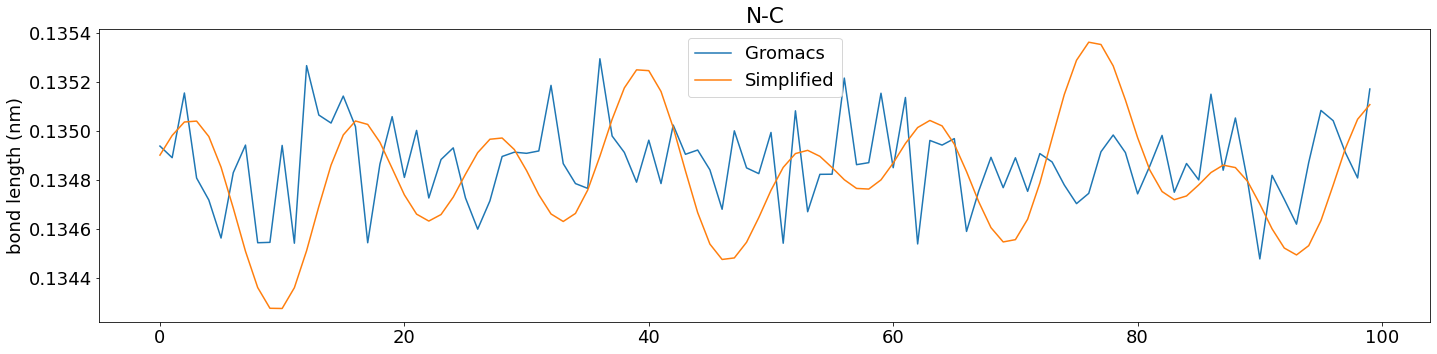

In [32]:
plot_each_radius(acttrj, prdtrj, label1, label2, 'N', 'C', meanstd=meanstd, axis=axis)

39


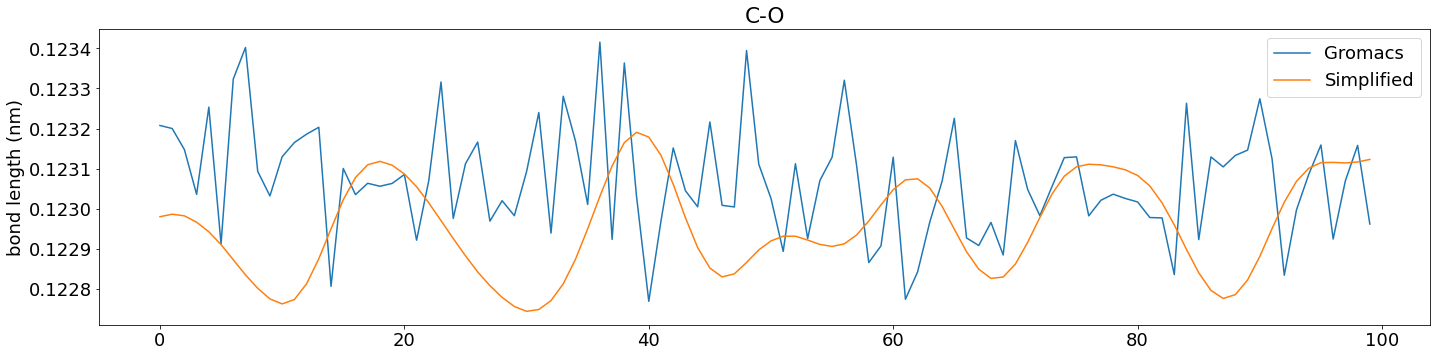

In [33]:
plot_each_radius(acttrj, prdtrj, label1, label2, 'C', 'O', meanstd=meanstd, axis=axis)

76


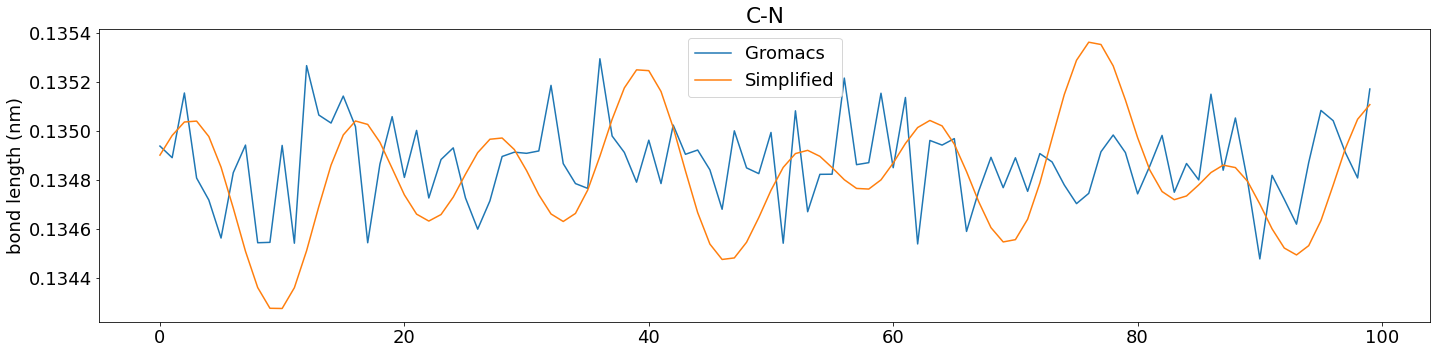

In [34]:
plot_each_radius(acttrj, prdtrj, label1, label2, 'C', 'N', meanstd=meanstd, axis=axis)

## each residue

In [35]:
axis = 0

### mean

In [36]:
meanstd = "mean"

0


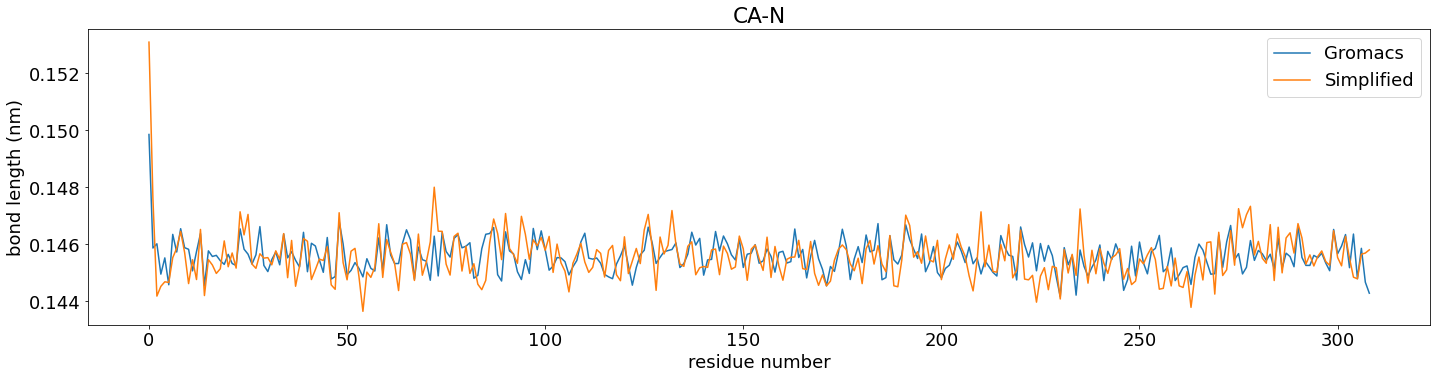

In [37]:
plot_each_radius(acttrj, prdtrj, label1, label2, 'CA', 'N', meanstd=meanstd, axis=axis)

308


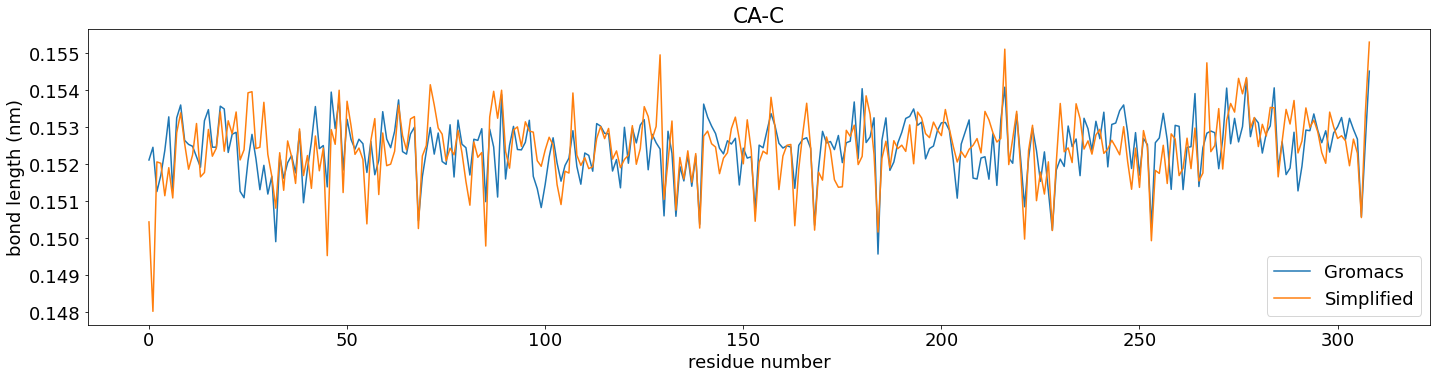

In [38]:
plot_each_radius(acttrj, prdtrj, label1, label2, 'CA', 'C', meanstd=meanstd, axis=axis)

0


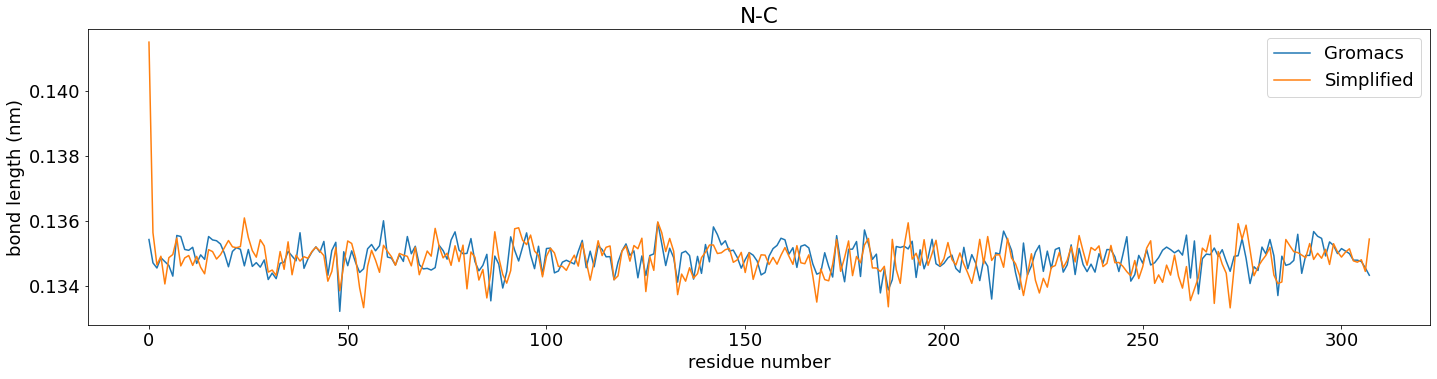

In [39]:
plot_each_radius(acttrj, prdtrj, label1, label2, 'N', 'C', meanstd=meanstd, axis=axis)

308


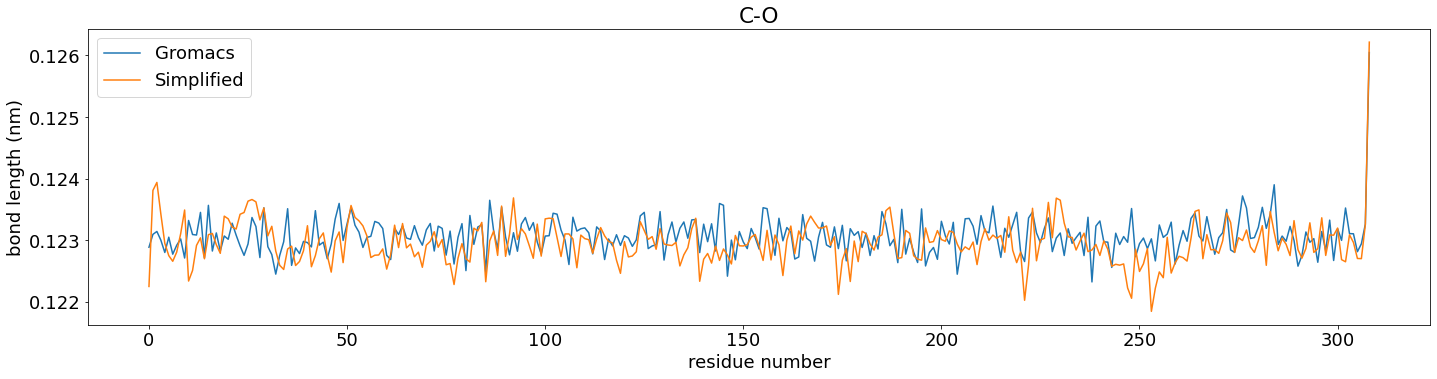

In [40]:
plot_each_radius(acttrj, prdtrj, label1, label2, 'C', 'O', meanstd=meanstd, axis=axis)

0


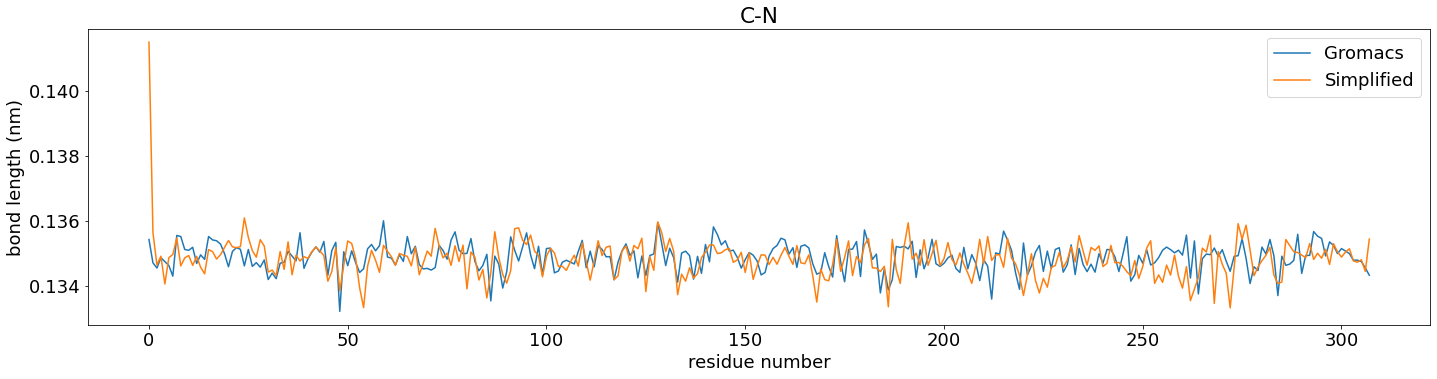

In [41]:
plot_each_radius(acttrj, prdtrj, label1, label2, 'C', 'N', meanstd=meanstd, axis=axis)

# ADF

In [42]:
def cal_degrees(coords_center, coords2, coords3):
    us = np.subtract(coords2, coords_center)
    vs = np.subtract(coords3, coords_center)
    
    inns = np.inner(us, vs)[0]
    norms = np.sqrt(np.sum(np.square(us), axis=1)) * np.sqrt(np.sum(np.square(vs), axis=1))

    cos_thetas = inns / norms
    degs = np.rad2deg(np.arccos(np.clip(cos_thetas, -1.0, 1.0)))
    return degs

In [43]:
approved_species_sets = {
    'CA': [set(['N', 'C'])],
    'N': [set(['CA', 'C'])],
    'C': [set(['CA', 'N']), set(['CA', 'O']), set(['N', 'O'])]
}

In [44]:
# def cal_degree_list(trj, center_species, species_set):
#     if species_set not in approved_species_sets[center_species]:
#         print('unapproved species sets')
    
    

#     l, u = SLICE_INDECES[center_species]

#     degree_list = []
#     for i in range(l, u):
#         coords_center = trj[:, i, :]
        
#         try:
#             if center_species == 'C' and species_set == set(['CA', 'N']):
#                 coords2 = trj[:, ADJACENT_INDECES[i][0][0], :]
#                 coords3 = trj[:, ADJACENT_INDECES[i][1][1], :]
#             elif center_species == 'C' and species_set == set(['O', 'N']):
#                 coords2 = trj[:, ADJACENT_INDECES[i][1][0], :]
#                 coords3 = trj[:, ADJACENT_INDECES[i][1][1], :]
#             else:
#                 coords2 = trj[:, ADJACENT_INDECES[i][0][0], :]
#                 coords3 = trj[:, ADJACENT_INDECES[i][1][0], :]
#         except IndexError:
#             continue

#         degree_list.extend(cal_degrees(coords_center, coords2, coords3).flatten().tolist())
        
#     return degree_list

def cal_degree_arr(trj, center_species, species_set):
    if species_set not in approved_species_sets[center_species]:
        print('unapproved species sets')

    l, u = SLICE_INDECES[center_species]

    degree_list = []
    for i in range(l, u):
        coords_center = trj[:, i, :]
        
        try:
            if center_species == 'C' and species_set == set(['CA', 'N']):
                coords2 = trj[:, ADJACENT_INDECES[i][0][0], :]
                coords3 = trj[:, ADJACENT_INDECES[i][1][1], :]
            elif center_species == 'C' and species_set == set(['O', 'N']):
                coords2 = trj[:, ADJACENT_INDECES[i][1][0], :]
                coords3 = trj[:, ADJACENT_INDECES[i][1][1], :]
            else:
                coords2 = trj[:, ADJACENT_INDECES[i][0][0], :]
                coords3 = trj[:, ADJACENT_INDECES[i][1][0], :]
        except IndexError:
            continue

        degree_list.append(cal_degrees(coords_center, coords2, coords3).flatten().tolist())
        
    return np.array(degree_list).transpose(1, 0)

In [45]:
N_FIGS = sum([len(li) for li in approved_species_sets.values()])

In [46]:
N_BINS = 30

def plot_adf(trj):
    fig = plt.figure(figsize=(20,5*N_FIGS))

    i = 0
    for species, spset_list in approved_species_sets.items():
        for spset in spset_list:
            i += 1
            fig.add_subplot(N_FIGS, 1, i)

            degree_list = cal_degree_list(trj, species, spset)
            hist, bins = np.histogram(degree_list, bins=N_BINS)

            plt.bar([(bins[i+1]+bins[i])/2 for i in range(len(hist))], hist)

            plt.xlabel("angle (degrees)", fontsize=14)
            plt.ylabel("Frequency", fontsize=14)

            sp1, sp2 = spset
            plt.title(f"{sp1}-{species}-{sp2} (mean: {int(round(np.mean(degree_list)))})", fontsize=14)
            plt.tight_layout()

In [47]:
def plot_adf_double(trj1, trj2, label1, label2):
    fig = plt.figure(figsize=(20,5*N_FIGS*2))

    i = 0
    for species, spset_list in approved_species_sets.items():
        for spset in spset_list:
            
            degree_arr1 = cal_degree_arr(trj1, species, spset)
            degree_arr2= cal_degree_arr(trj2, species, spset)
            
            degree_list1 = degree_arr1.flatten().tolist()
            degree_list2 = degree_arr2.flatten().tolist()
            
            binmax = max(degree_list1 + degree_list2)
            binmin = min(degree_list1 + degree_list2)

           # trj1
            i += 1
            fig.add_subplot(N_FIGS*2, 1, i)
            
            hist, bins = np.histogram(degree_list1, range=(binmin, binmax), bins=N_BINS)

            plt.bar([f"{int(round((bins[i]+bins[i+1])/2))}" for i in range(len(hist))], hist, label=label1)

            plt.xlabel("angle (degrees)")
            plt.ylabel("Frequency")

            sp1, sp2 = spset
            plt.title(f"{sp1}-{species}-{sp2} (mean: {int(round(np.mean(degree_list1)))}, std: {round(np.std(degree_list1),2)})")
            
            plt.legend()
            
            # trj2    
            i += 1
            fig.add_subplot(N_FIGS*2, 1, i)
            
            hist, bins = np.histogram(degree_list2, range=(binmin, binmax), bins=N_BINS)

            plt.bar([f"{int(round((bins[i]+bins[i+1])/2))}" for i in range(len(hist))], hist, color="#ff7f00", label=label2)
            

            plt.xlabel("angle (degrees)")
            plt.ylabel("Frequency")

            sp1, sp2 = spset
            plt.title(f"{sp1}-{species}-{sp2} (mean: {int(round(np.mean(degree_list2)))}, std: {round(np.std(degree_list2),2)})")
            
            plt.legend()
    
    plt.tight_layout()

In [48]:
# def plot_each_adf_mean(trj):
#     fig = plt.figure(figsize=(20,3*N_FIGS))

#     i = 0
#     for species, spset_list in approved_species_sets.items():
#         for spset in spset_list:
#             i += 1
#             fig.add_subplot(N_FIGS, 1, i)

#             degree_list = cal_degree_list(trj, species, spset)
#             hist, bins = np.histogram(degree_list, bins=N_BINS)

#             degree_list_each_time = [cal_degree_list(trj[[t], :, :], species, spset) for t in range(trj.shape[0])]
#             mean_angle_each_time = [np.mean(degree_list) for degree_list in degree_list_each_time]

#             plt.plot(list(range(trj.shape[0])), mean_angle_each_time)
#             plt.scatter(list(range(trj.shape[0])), mean_angle_each_time)

#             sp1, sp2 = spset
#             plt.title(f"{sp1}-{species}-{sp2}")
#             plt.tight_layout()

In [49]:
def plot_each_adf(trj1, trj2, label1, label2, species, spset, meanstd="mean", axis=1):
    fig = plt.figure(figsize=(20,5))
    fig.add_subplot(1, 1, 1)
    
    sp1, sp2 = spset

    if meanstd == "mean":
        degree_list1 = cal_degree_arr(trj1, species, spset).mean(axis=axis).tolist()
        degree_list2 = cal_degree_arr(trj2, species, spset).mean(axis=axis).tolist()
    elif meanstd == "std":
        degree_list1 = cal_degree_arr(trj1, species, spset).std(axis=axis).tolist()
        degree_list2 = cal_degree_arr(trj2, species, spset).std(axis=axis).tolist()

    sp1, sp2 = spset
    plt.plot(list(range(len(degree_list1))), degree_list1, label=label1)
    plt.plot(list(range(len(degree_list2))), degree_list2, label=label2)
    plt.tight_layout()
    
    plt.title(f"{sp1}-{species}-{sp2}")
    
    if axis==1:
        plt.xlabel("steps (×2fs)")
    else:
        plt.xlabel("residue number")
    plt.ylabel("Std (degrees)")

    plt.legend()

## double whole time

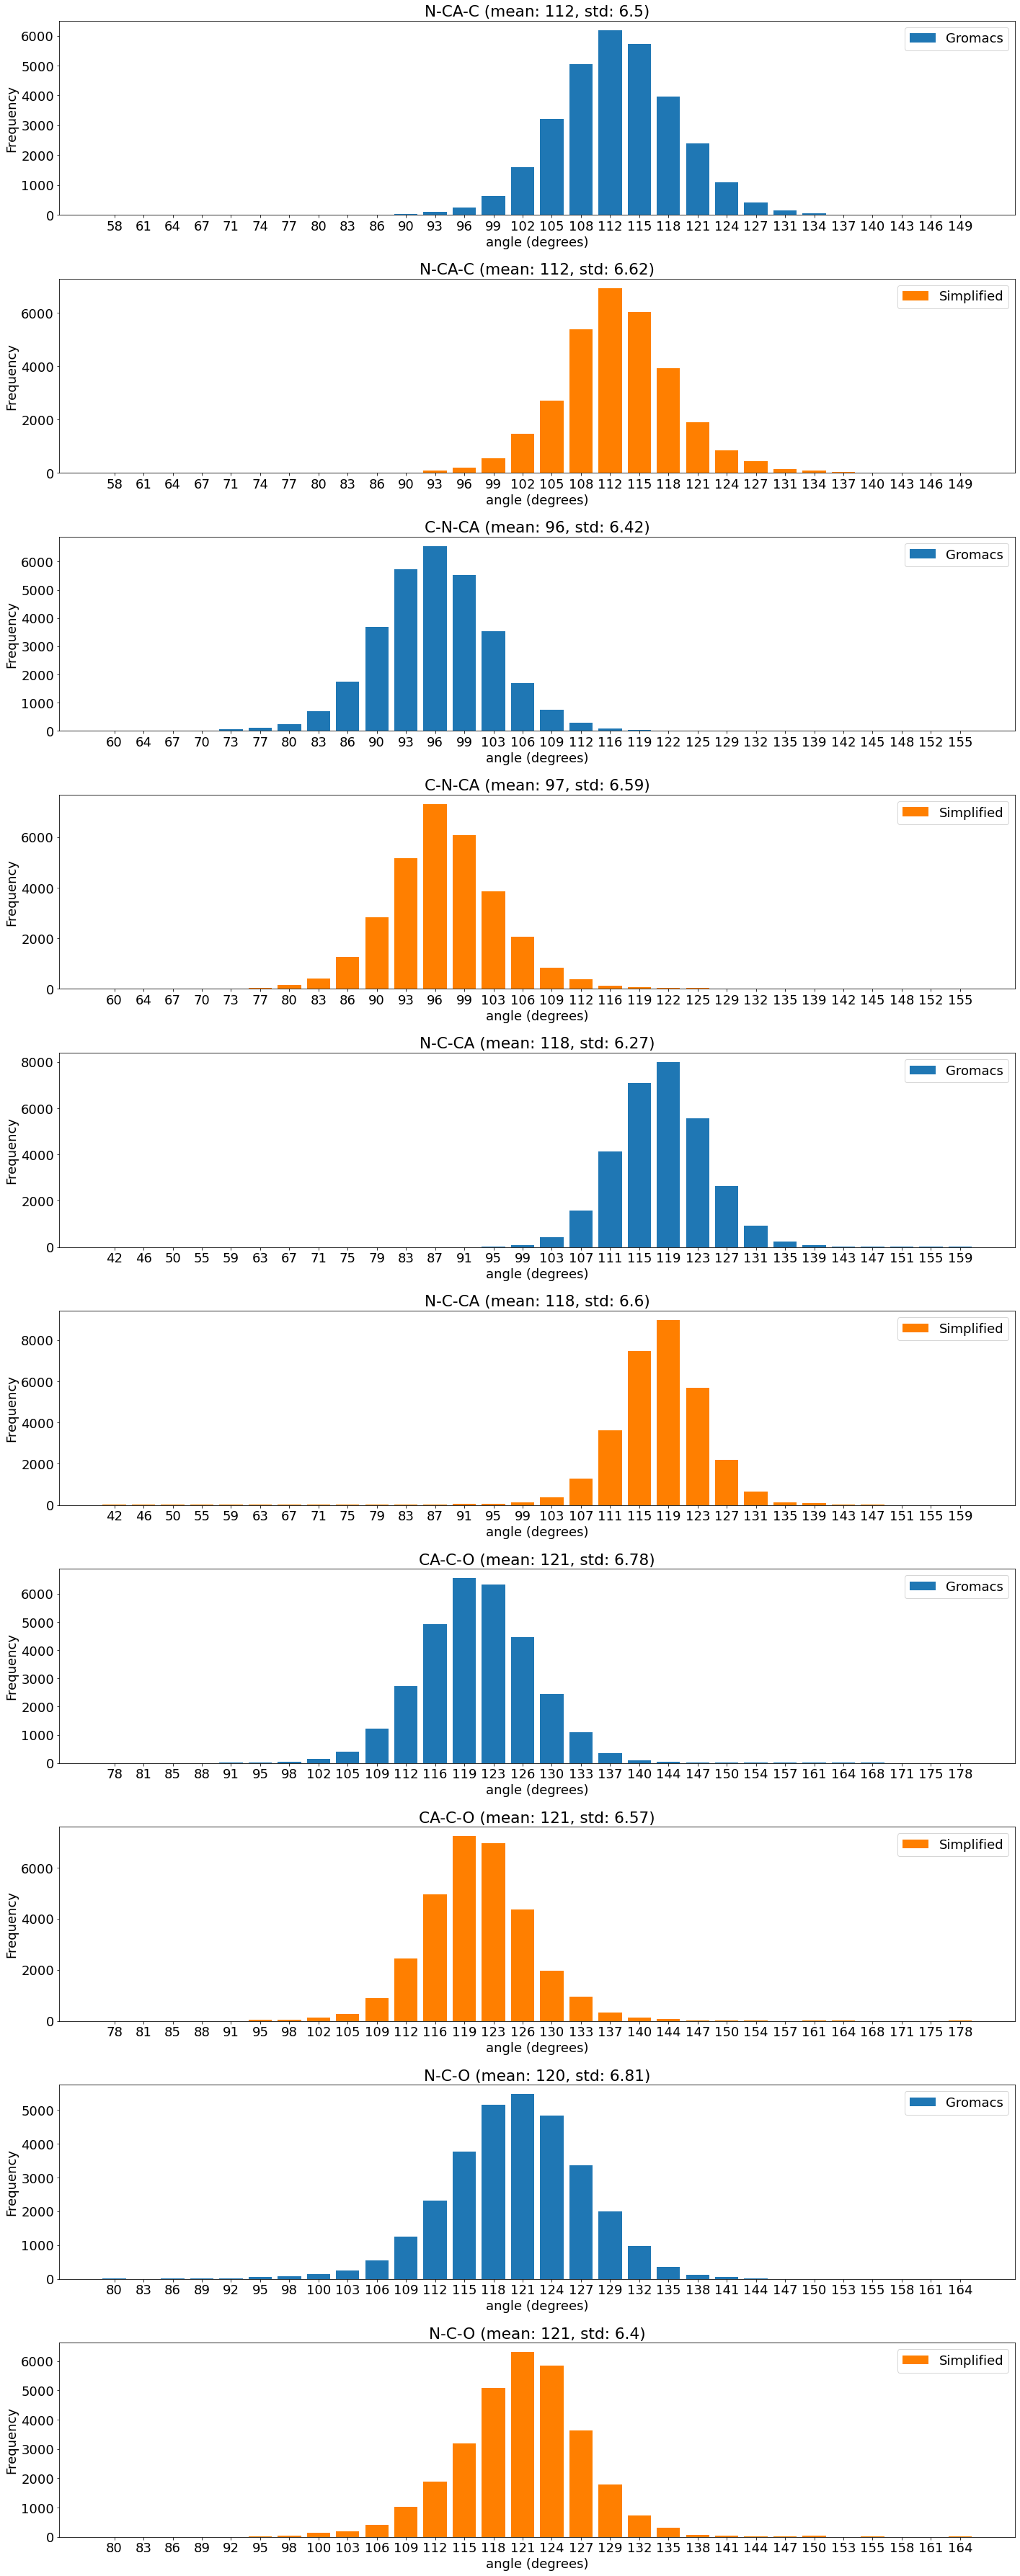

In [50]:
plot_adf_double(acttrj, prdtrj, "Gromacs", "Simplified")

## each time

In [51]:
axis=1

### mean

In [52]:
meanstd = "mean"

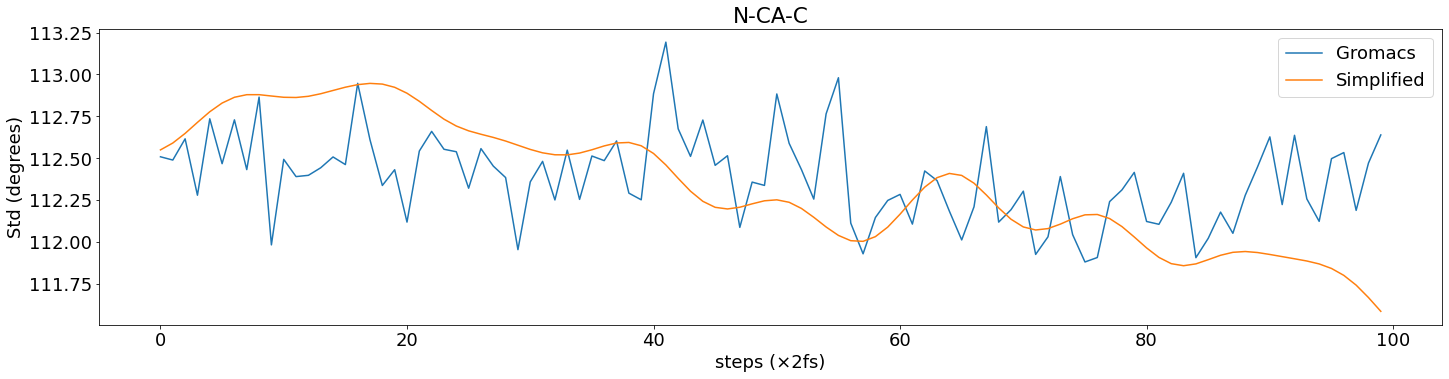

In [53]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'CA', {'N', 'C'}, meanstd=meanstd, axis=axis)

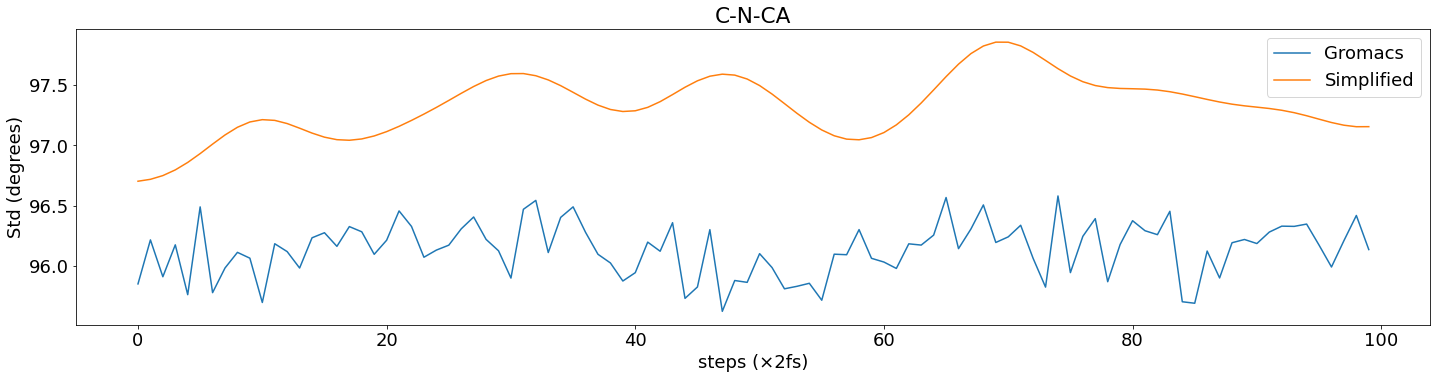

In [54]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'N', {'CA', 'C'}, meanstd=meanstd, axis=axis)

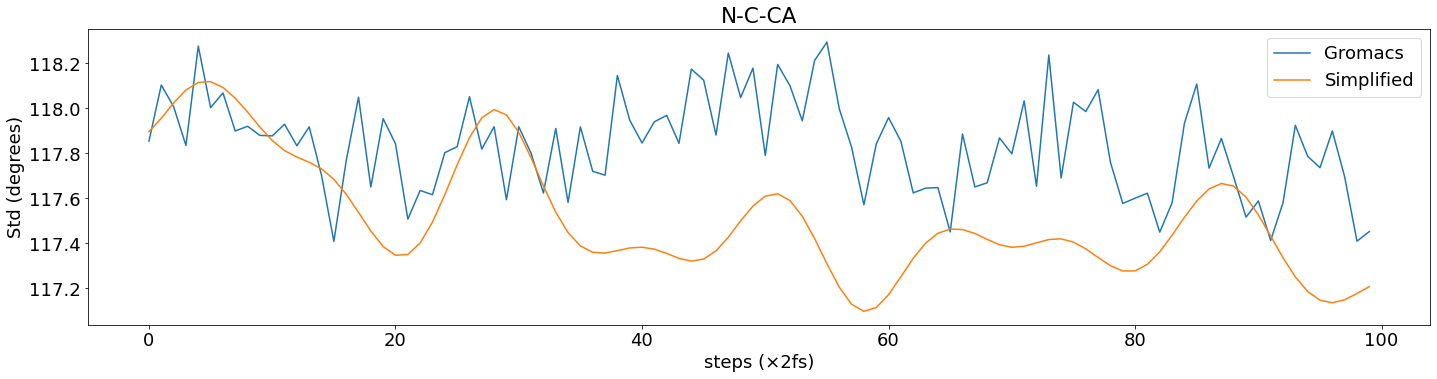

In [55]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'C', {'N', 'CA'}, meanstd=meanstd, axis=axis)

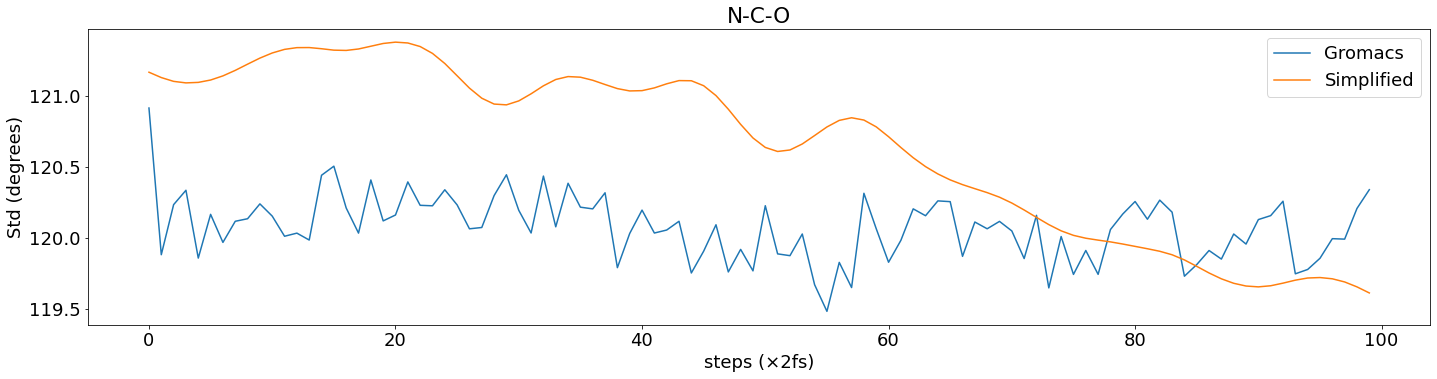

In [56]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'C', {'O', 'N'}, meanstd=meanstd, axis=axis)

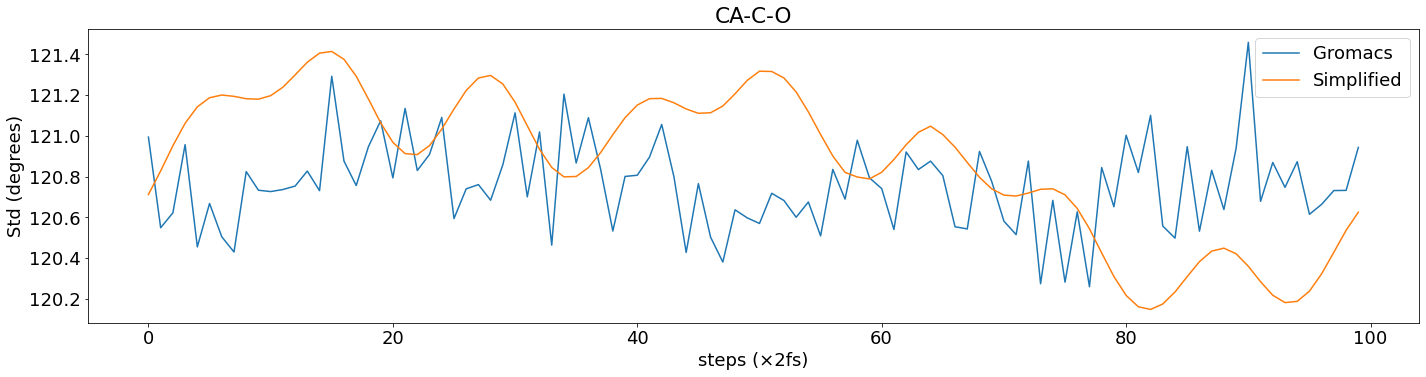

In [57]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'C', {'O', 'CA'}, meanstd=meanstd, axis=axis)

### std

In [58]:
meanstd = "std"

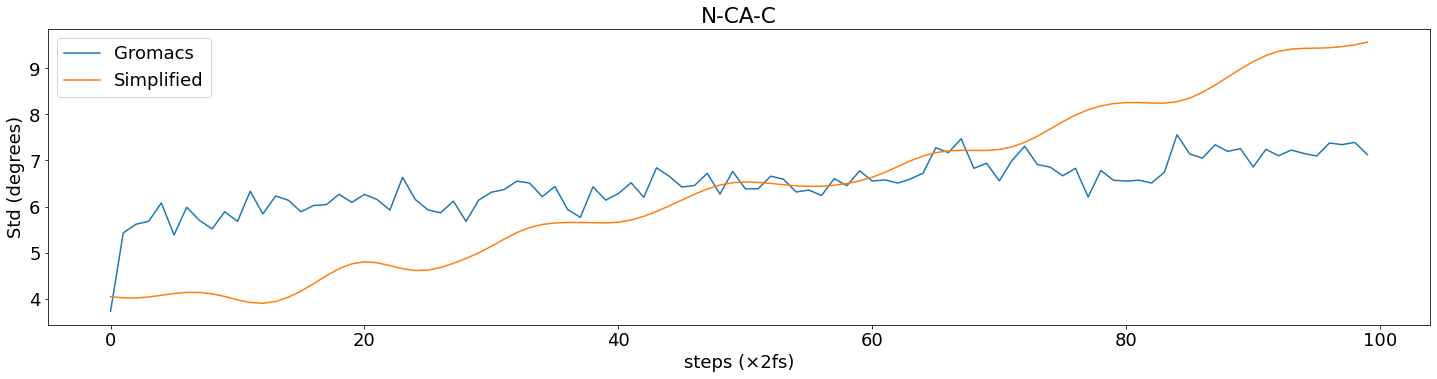

In [59]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'CA', {'N', 'C'}, meanstd=meanstd, axis=axis)

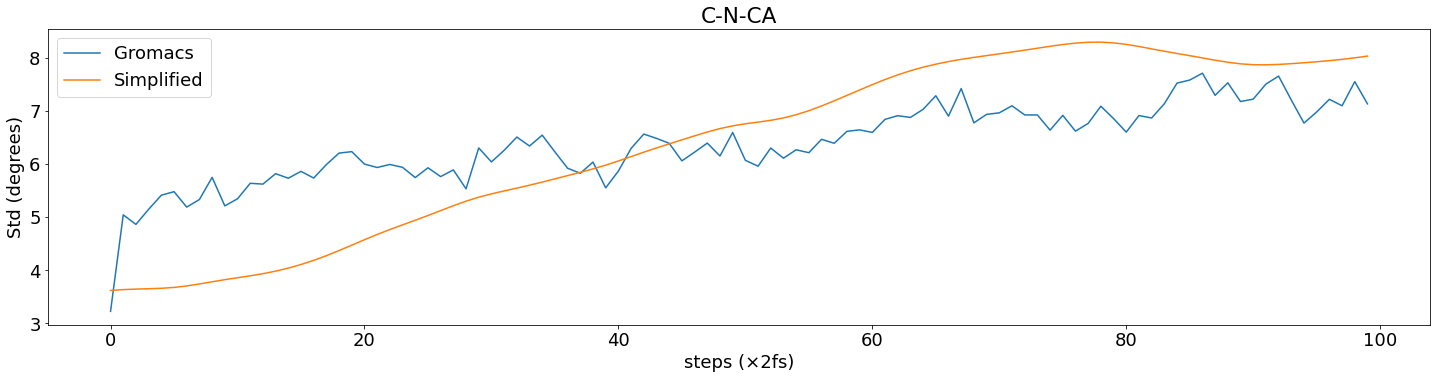

In [60]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'N', {'CA', 'C'}, meanstd=meanstd, axis=axis)

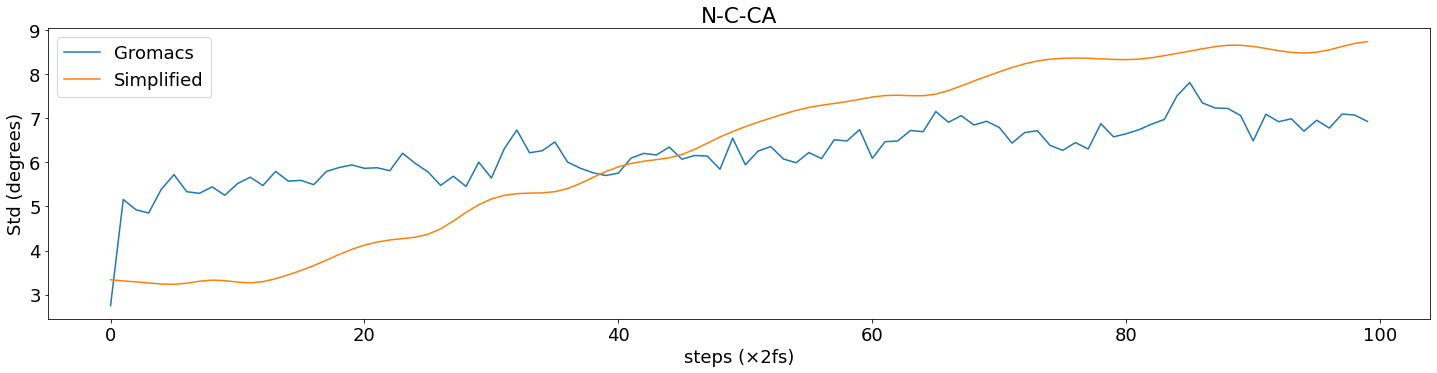

In [61]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'C', {'N', 'CA'}, meanstd=meanstd, axis=axis)

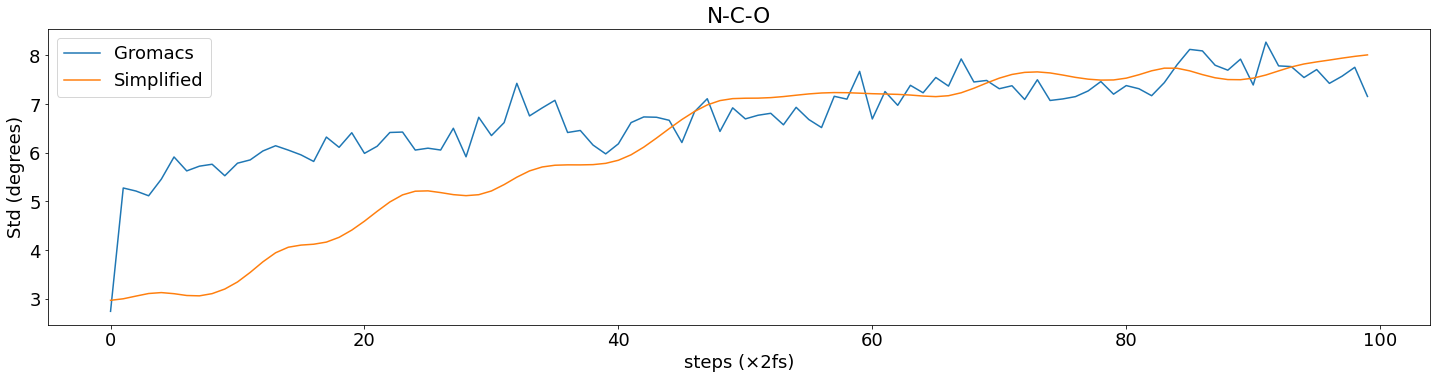

In [62]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'C', {'O', 'N'}, meanstd=meanstd, axis=axis)

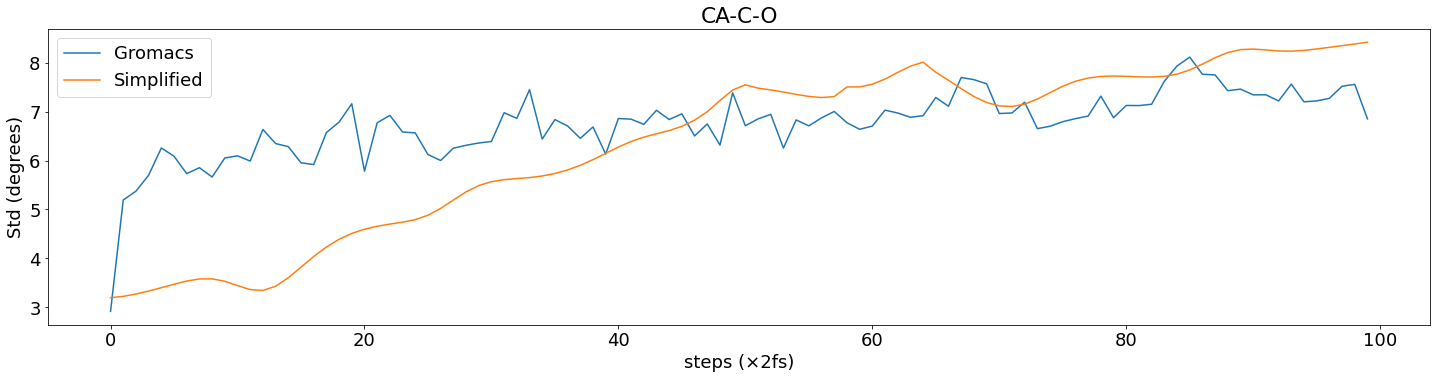

In [63]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'C', {'O', 'CA'}, meanstd=meanstd, axis=axis)

## each residue

In [64]:
axis=0

### mean

In [65]:
meanstd = "mean"

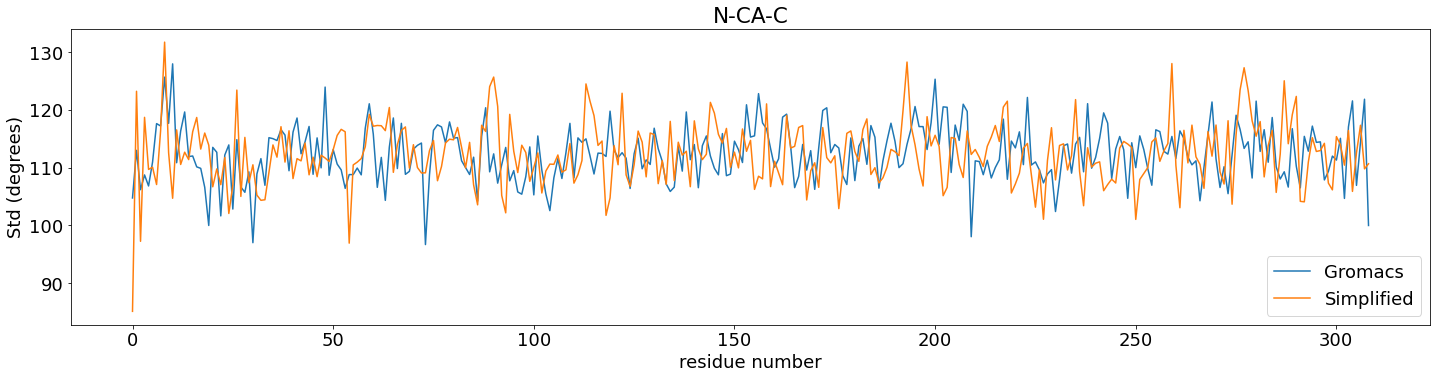

In [66]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'CA', {'N', 'C'}, meanstd=meanstd, axis=axis)

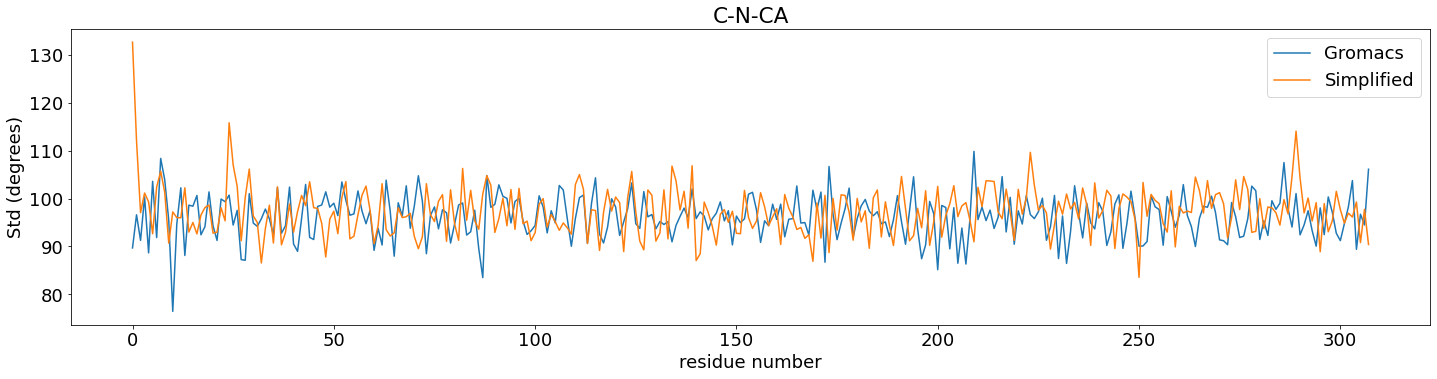

In [67]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'N', {'CA', 'C'}, meanstd=meanstd, axis=axis)

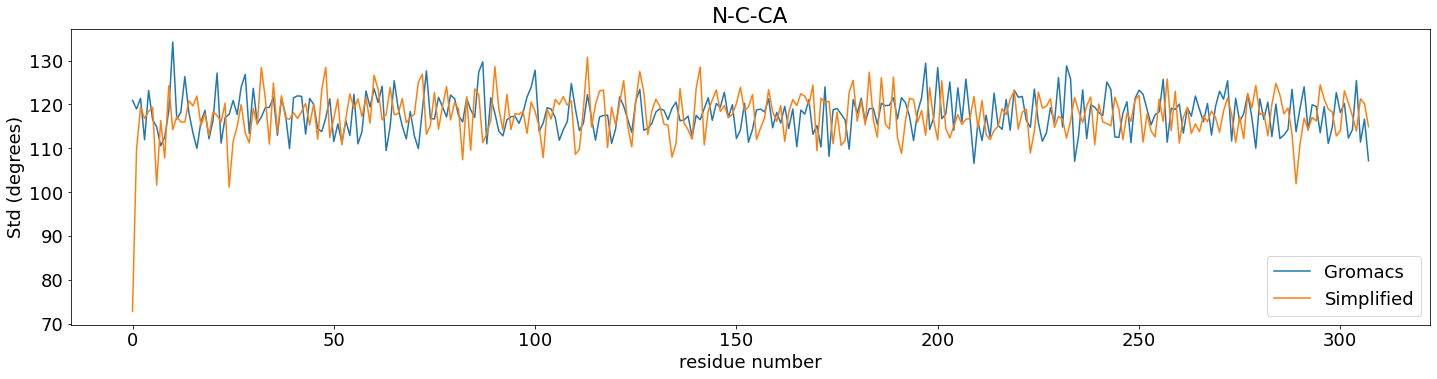

In [68]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'C', {'N', 'CA'}, meanstd=meanstd, axis=axis)

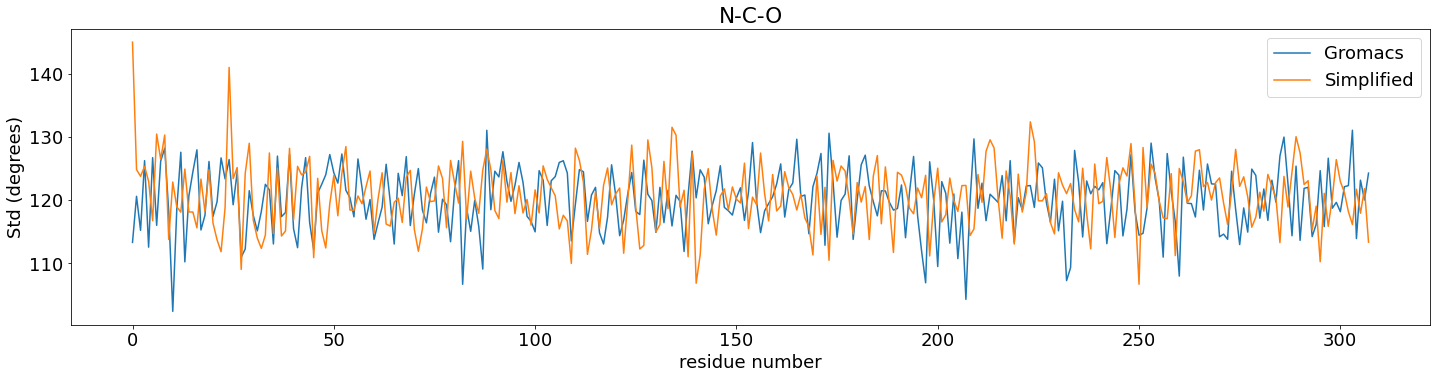

In [69]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'C', {'O', 'N'}, meanstd=meanstd, axis=axis)

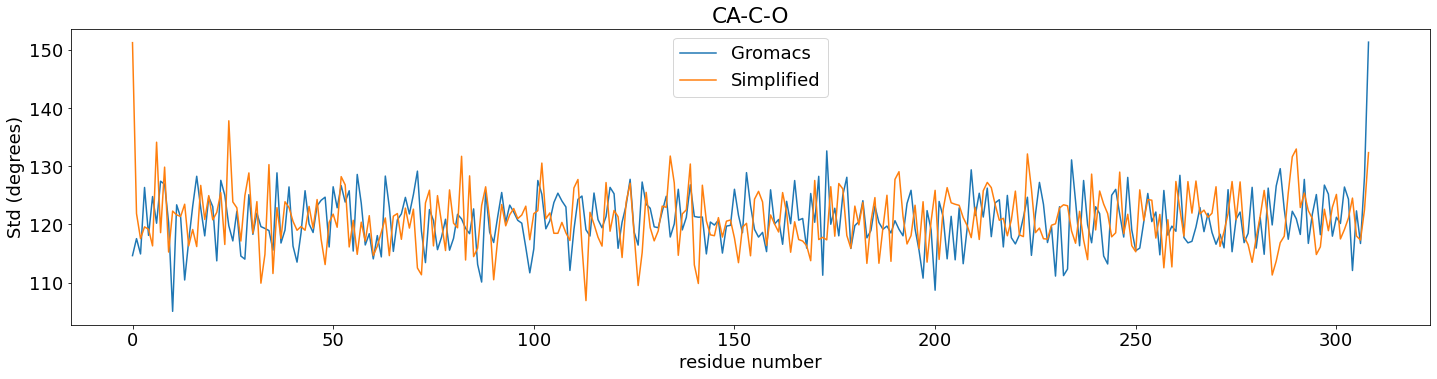

In [70]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'C', {'O', 'CA'}, meanstd=meanstd, axis=axis)

### std

In [71]:
meanstd = "std"

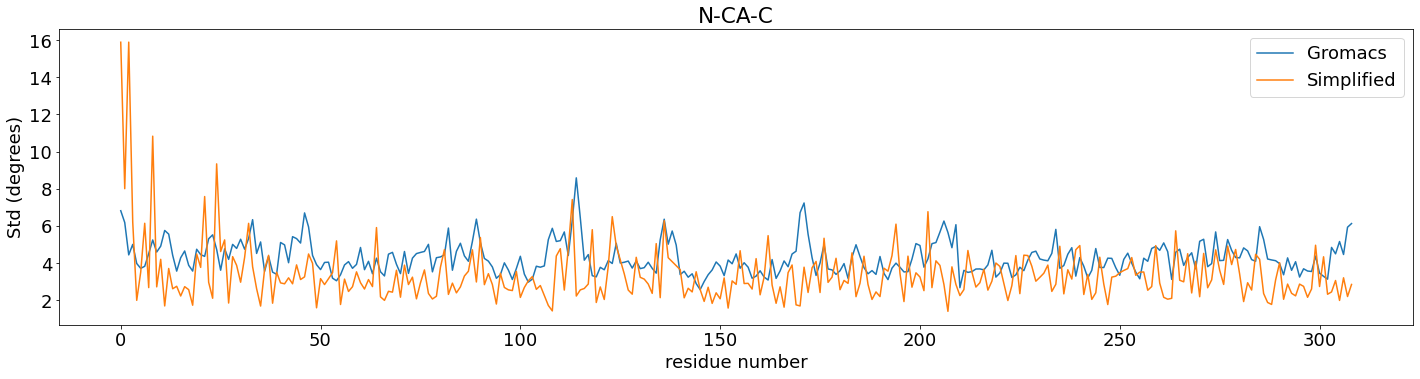

In [72]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'CA', {'N', 'C'}, meanstd=meanstd, axis=axis)

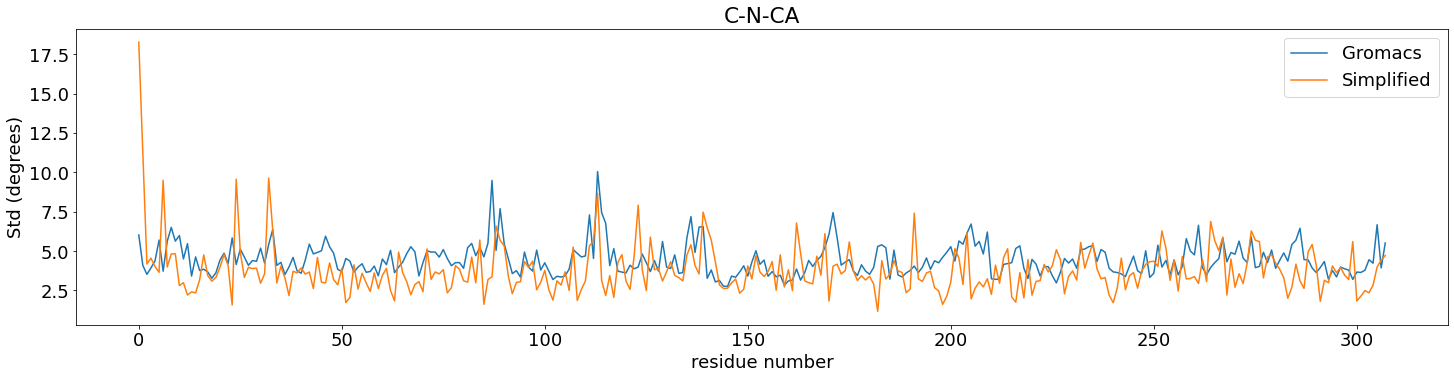

In [73]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'N', {'CA', 'C'}, meanstd=meanstd, axis=axis)

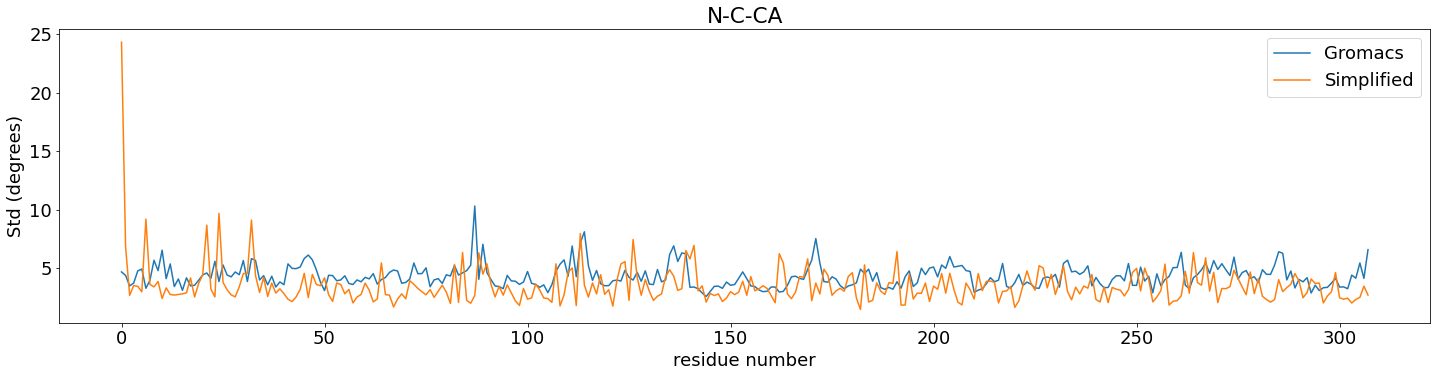

In [74]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'C', {'N', 'CA'}, meanstd=meanstd, axis=axis)

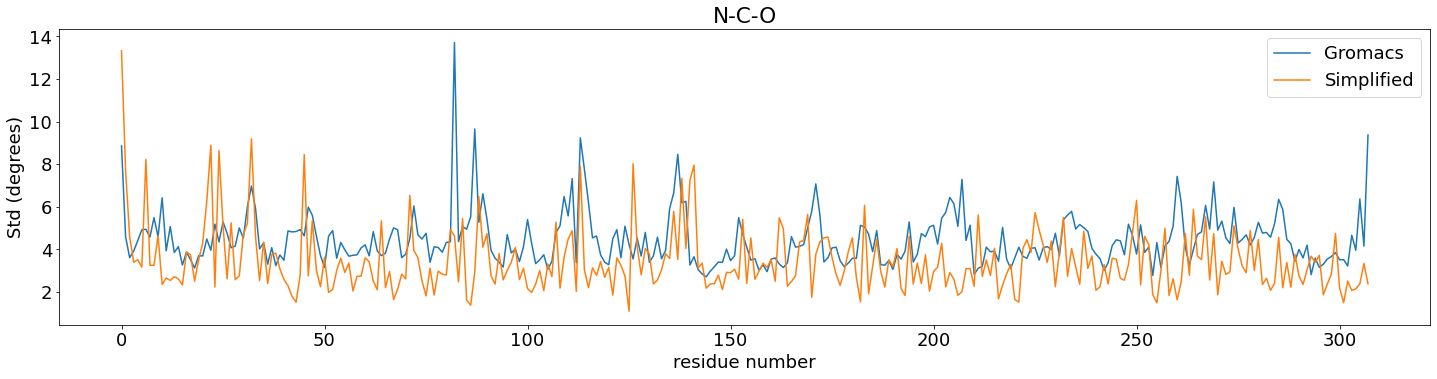

In [75]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'C', {'O', 'N'}, meanstd=meanstd, axis=axis)

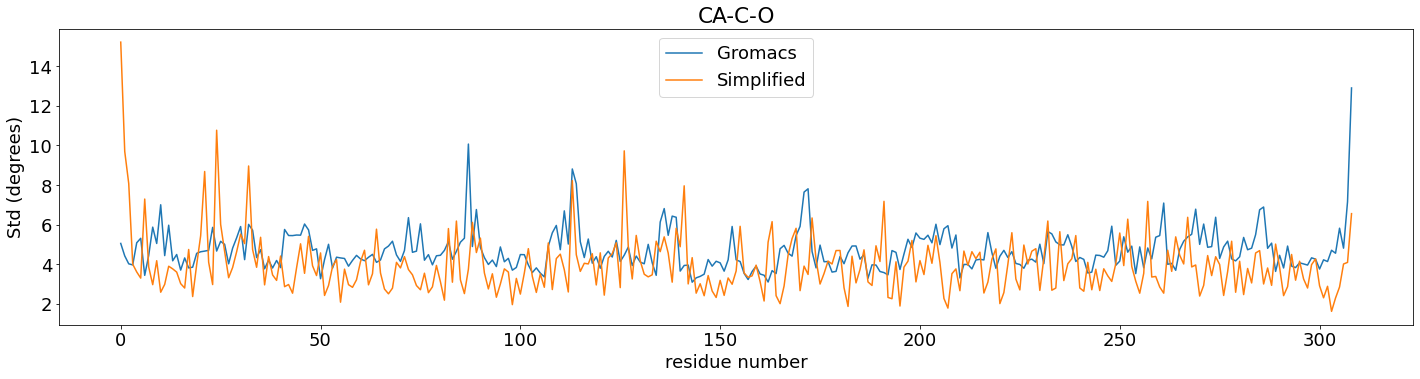

In [76]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'C', {'O', 'CA'}, meanstd=meanstd, axis=axis)

# 二面角

注意！：　必ずrearrangeする

In [77]:
l, u = SLICE_INDECES['N']
N_indeces = [ARRANGED_INDECES[x] for x in range(l, u)]

In [78]:
atom_align = [ATOM_ALIGN[x] for x in REARRANGED_INDECES]

In [79]:
def dihedral(p0, p1, p2, p3): 
    """Praxeolitic formula 
    1 sqrt, 1 cross product""" 
#     p0 = p[0] 
#     p1 = p[1] 
#     p2 = p[2] 
#     p3 = p[3] 

    b0 = -1.0*(p1 - p0) 
    b1 = p2 - p1 
    b2 = p3 - p2 

    # normalize b1 so that it does not influence magnitude of vector 
    # rejections that come next 
    b1 = np.divide(b1, np.linalg.norm(b1))

    # vector rejections 
    # v = projection of b0 onto plane perpendicular to b1 
    # = b0 minus component that aligns with b1 
    # w = projection of b2 onto plane perpendicular to b1 
    # = b2 minus component that aligns with b1 
    v = b0 - np.dot(b0, b1)*b1 
    w = b2 - np.dot(b2, b1)*b1 

    # angle between v and w in a plane is the torsion angle 
    # v and w may not be normalized but that's fine since tan is y/x 
    x = np.dot(v, w) 
    y = np.dot(np.cross(b1, v), w) 
    return np.degrees(np.arctan2(y, x)) 

In [80]:
dihedral(
    np.array([1,1,0]),
    np.array([1,0,0]),
    np.array([0,0,0]),
    np.array([1/2,-1/2,1])
)

-116.56505117707799

In [81]:
def cal_normal_vector(coord1, coord2, coord3):
    u = coord2 - coord1
    v = coord3 - coord1
    return np.cross(u, v)

def dihedral2(p0, p1, p2, p3): 
    u = cal_normal_vector(p0, p1, p2)
    v = cal_normal_vector(p1, p2, p3)
    
    inn = np.inner(u, v)
    norm = np.sqrt(np.sum(np.square(u), axis=0)) * np.sqrt(np.sum(np.square(v), axis=0))
    
    cos_thetas = inn / norm
    degs = np.rad2deg(np.arccos(np.clip(cos_thetas, -1.0, 1.0)))
    return degs

In [82]:
# dihedral2(
#     np.array([1,1,0]),
#     np.array([1,0,0]),
#     np.array([0,0,0]),
#     np.array([1/2,-1/2,1])
# )

In [83]:
def cal_3dihedrals(struct):  # このstructはN,CA,CB, C,Oの並びである前提
    phi_list = []
    psi_list = []
    omega_list = []
    for i in N_indeces[1:-1]:
        phi_list.append(dihedral(struct[i-2], struct[i], struct[i+1], struct[i+3]))
        psi_list.append(dihedral(struct[i], struct[i+1], struct[i+3], struct[i+5]))
        omega_list.append(dihedral(struct[i-4], struct[i-2], struct[i], struct[i+1]))
#         if atom_align[i+2] == "CB":
#             phi_list.append(dihedral(struct[i-2], struct[i], struct[i+1], struct[i+3]))
#             psi_list.append(dihedral(struct[i], struct[i+1], struct[i+3], struct[i+5]))
#             omega_list.append(dihedral(struct[i-4], struct[i-2], struct[i], struct[i+1]))
#         elif atom_align[i+2] == "C":
#             phi_list.append(dihedral(struct[i-2], struct[i], struct[i+1], struct[i+2]))
#             psi_list.append(dihedral(struct[i], struct[i+1], struct[i+2], struct[i+4]))
#             omega_list.append(dihedral(struct[i-3], struct[i-2], struct[i], struct[i+1]))

    return phi_list, psi_list, omega_list

In [84]:
def dihedral_eachtime(trj):
    trj = trj[:, REARRANGED_INDECES, :]
    phi_list, psi_list, omega_list = [], [], []
    for t in range(trj.shape[0]):
        phi, psi, omega = cal_3dihedrals(trj[t])
        phi_list.append(phi)
        psi_list.append(psi)
        omega_list.append(omega)
    
    return np.array(phi_list), np.array(psi_list), np.array(omega_list)

    plt.scatter(np.array(phi_list), psi_list)

In [85]:
def ramachandran_plot(phi_array, psi_array, alpha=0.1):
    fig = plt.figure(figsize=(10,10))
    fig.add_subplot(1, 1, 1)

    x = phi_array.flatten()
    y = psi_array.flatten()
    plt.scatter(x, y, alpha=alpha)
    plt.xlim(-180, 180)
    plt.ylim(-180, 180)
    plt.xlabel(u'\u03c6 [degrees]')
    plt.ylabel(u'\u03c8 [degrees]')

In [86]:
def dihedral_hist(arr1, arr2, title):
    title = {"phi": u'\u03c6', 'psi':u'\u03c8', "omega":u'\u03c9'}[title]
    
    arr1 = arr1.flatten().tolist()
    arr2 = arr2.flatten().tolist()
    fig = plt.figure(figsize=(20,10))
            
    binmax = max(arr1 + arr2)
    binmin = min(arr1 + arr2)

   # arr1
    fig.add_subplot(2, 1, 1)

    hist, bins = np.histogram(arr1, range=(binmin, binmax), bins=N_BINS)

    plt.bar([f"{int(round((bins[i]+bins[i+1])/2))}" for i in range(len(hist))], hist)

    plt.xlabel(f"{title} [degrees]")
    plt.ylabel("Frequency")

#     plt.title(f"{title} (mean: {round(np.mean(arr1), 2)}, std: {round(np.std(arr1), 2)})")
    plt.title(f"{title}")

    # arr2
    fig.add_subplot(2, 1, 2)

    hist, bins = np.histogram(arr2, range=(binmin, binmax), bins=N_BINS)

    plt.bar([f"{int(round((bins[i]+bins[i+1])/2))}" for i in range(len(hist))], hist, color="#ff7f00")

    plt.xlabel(f"{title} [degrees]")
    plt.ylabel("Frequency")

#     plt.title(f"{title} (mean: {round(np.mean(arr2), 2)}, std: {round(np.std(arr2), 2)})")
    plt.title(f"{title}")
    
    plt.tight_layout()

## 計算

In [87]:
phi_array1, psi_array1, omega_array1 = dihedral_eachtime(acttrj)

In [88]:
phi_array2, psi_array2, omega_array2 = dihedral_eachtime(prdtrj)
phi_array2.shape

(100, 307)

## ramachandran

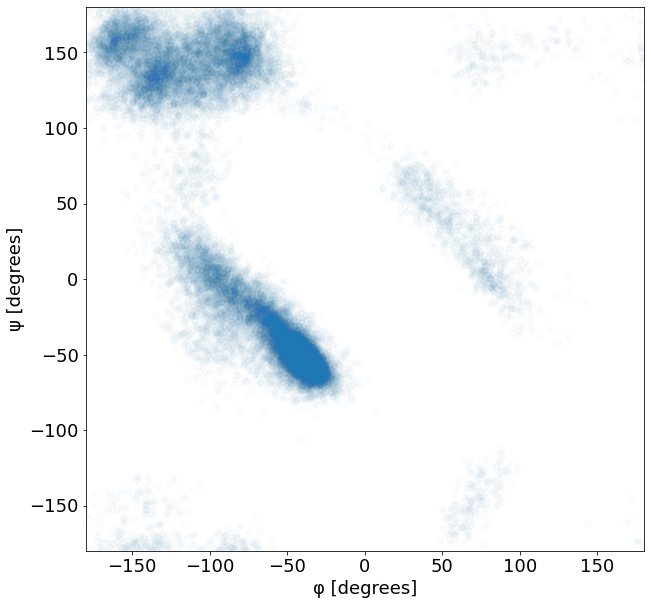

In [89]:
ramachandran_plot(phi_array1, psi_array1, alpha=0.02)

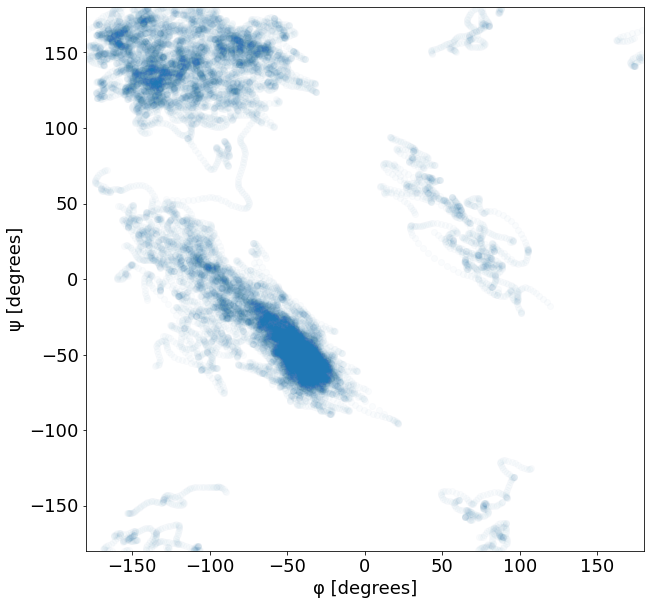

In [90]:
ramachandran_plot(phi_array2, psi_array2, alpha=0.02)

## hist

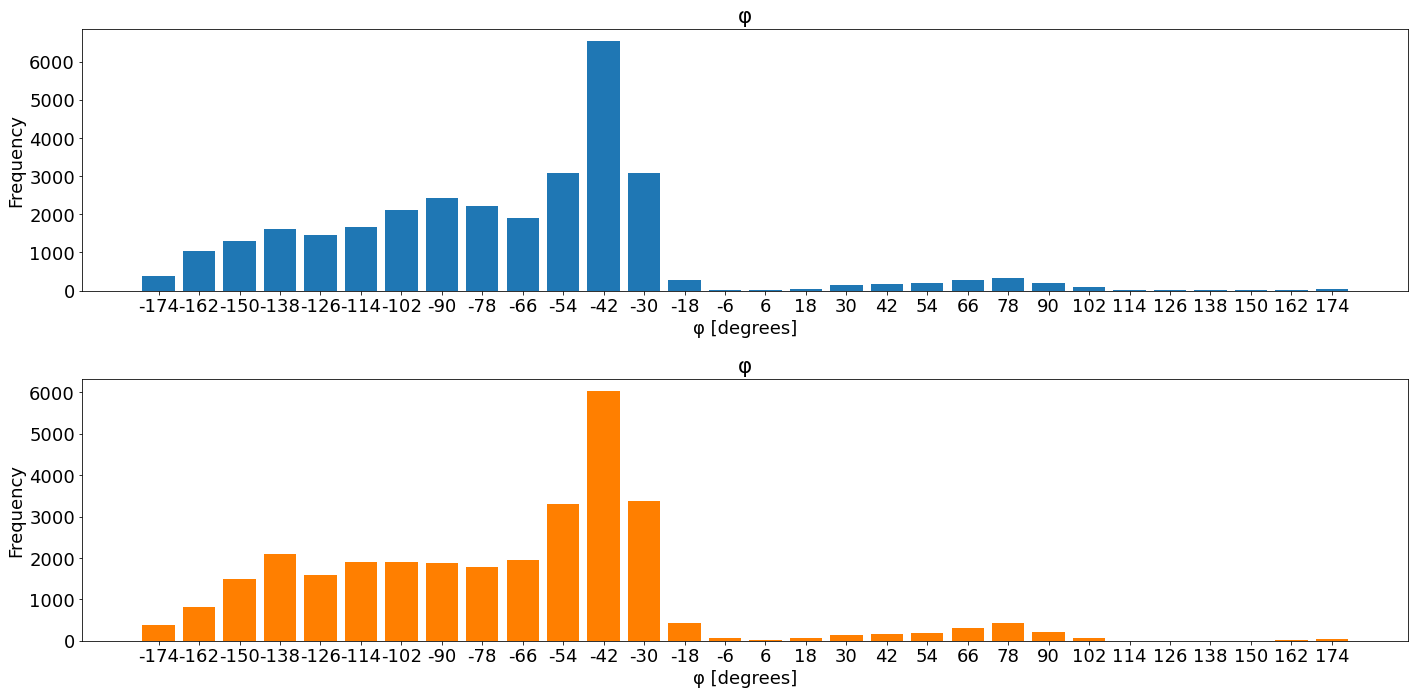

In [91]:
dihedral_hist(phi_array1, phi_array2, "phi")

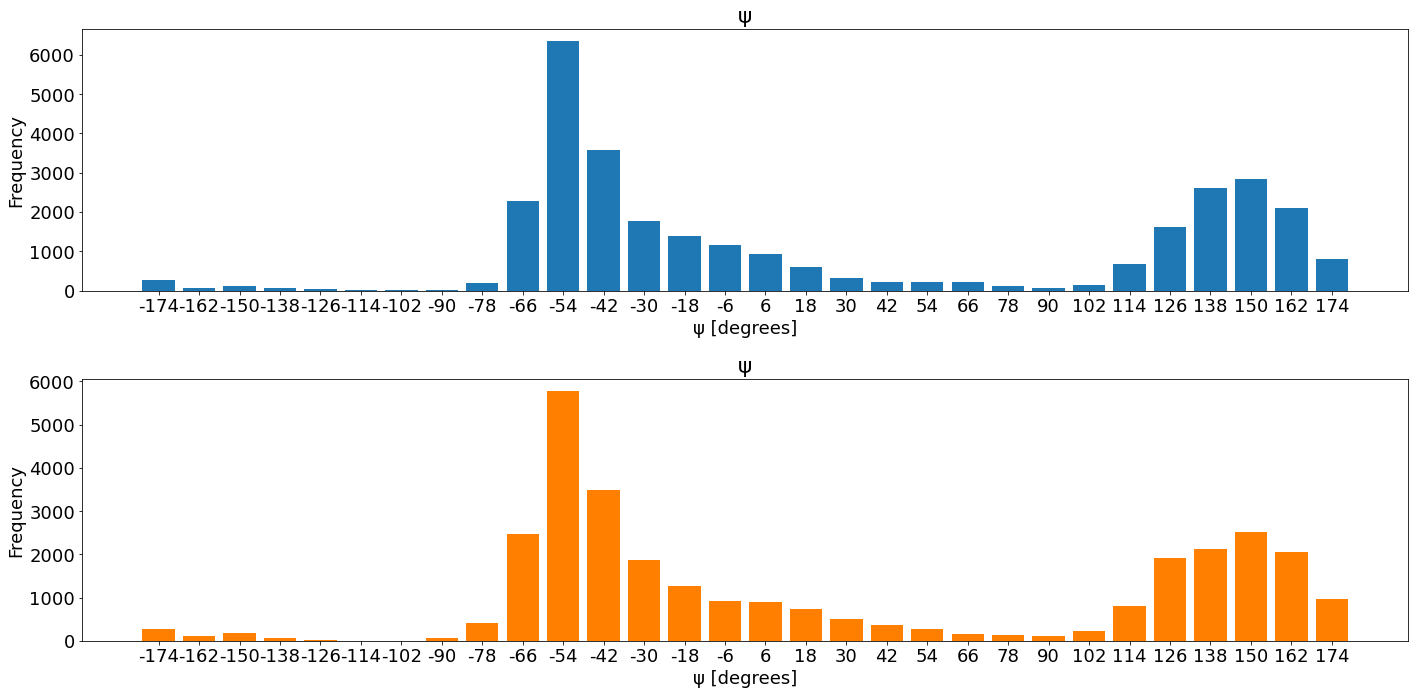

In [92]:
dihedral_hist(psi_array1, psi_array2, "psi")

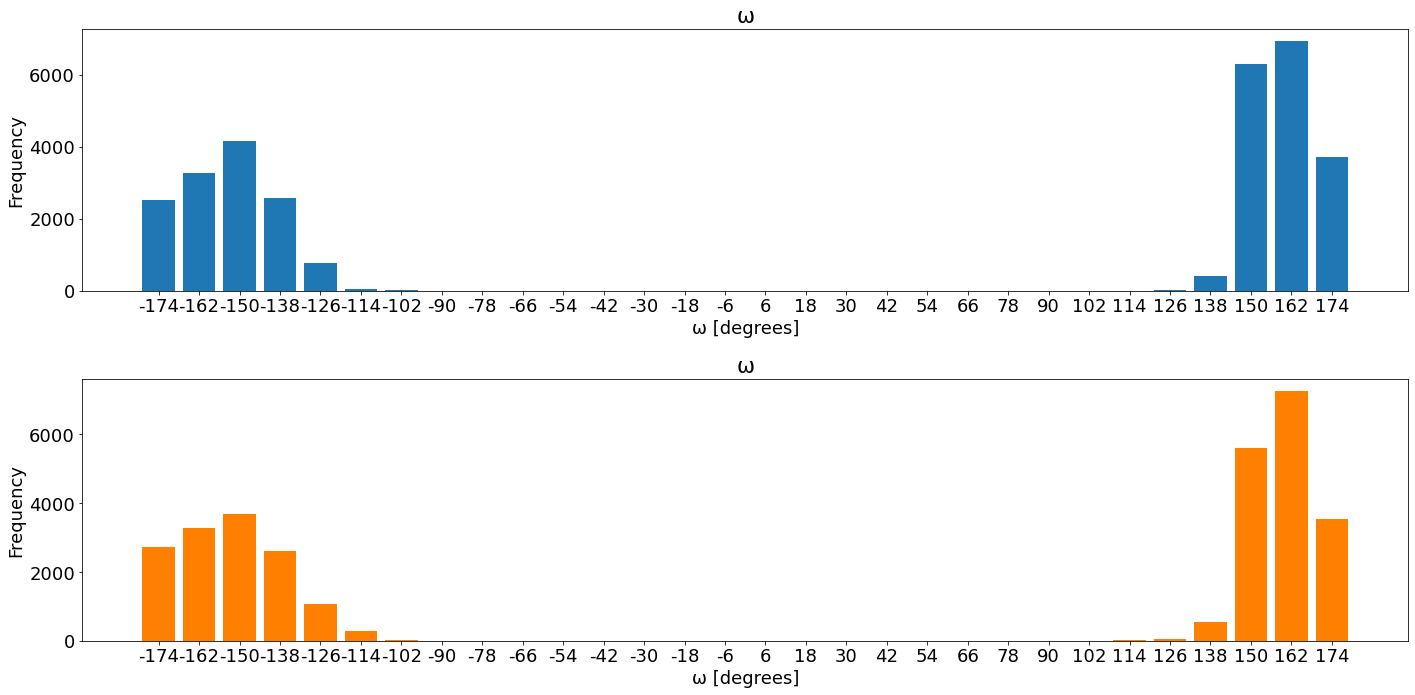

In [93]:
dihedral_hist(omega_array1, omega_array2, "omega")

## mean each residue

In [94]:
np.max(psi_array1)

179.9652150731649

In [95]:
np.min(psi_array2)

-179.9814745004683

In [96]:
axis=0

In [97]:
def dihedral_mean(arr):
    arr = arr.transpose(1, 0)

    for i, arr_residue in enumerate(arr):
        for t in range(arr_residue.shape[0]-1):
            d1, d2 = arr_residue[t:t+2]
            if d1 - d2 >= 180:
                arr_residue[t+1] = d2 + 360
            elif d1 - d2 <= -180:
                arr_residue[t+1] = d2 - 360

#         if np.max(arr_residue) > 180 or np.min(arr_residue) < -180:
#             print(i, np.max(arr_residue), np.min(arr_residue))

        arr[i] = arr_residue
    
    means = arr.mean(axis=1)
    new_means = []
    for m in means:
        if m >=180:
            new_means.append(m-180)
        elif m<=-180:
            new_means.append(m+180)
        else:
            new_means.append(m)
    
    return new_means

In [98]:
def dihedral_std(arr):
    arr = arr.transpose(1, 0)

    for i, arr_residue in enumerate(arr):
        for t in range(arr_residue.shape[0]-1):
            d1, d2 = arr_residue[t:t+2]
            if d1 - d2 >= 180:
                arr_residue[t+1] = d2 + 360
            elif d1 - d2 <= -180:
                arr_residue[t+1] = d2 - 360
        arr[i] = arr_residue
    
    return arr.std(axis=1)

In [99]:
# _ = dihedral_mean(psi_array2)

Text(0, 0.5, 'ω [degrees]')

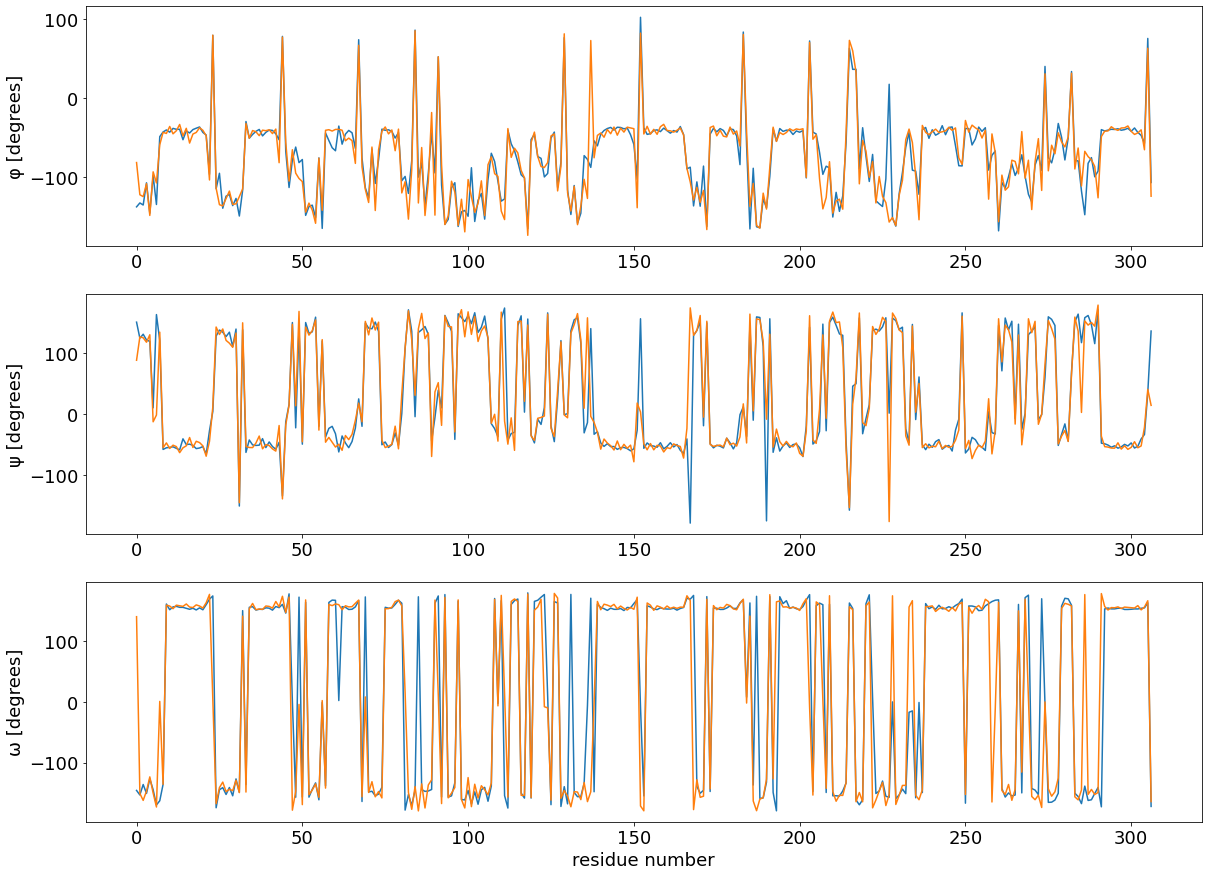

In [100]:
fig = plt.figure(figsize=(20,15))

fig.add_subplot(3, 1, 1)
# li = phi_array1.mean(axis=axis)
li = dihedral_mean(phi_array1.copy())
plt.plot(list(range(len(li))), li)
# li = phi_array2.mean(axis=axis)
li = dihedral_mean(phi_array2.copy())
plt.plot(list(range(len(li))), li)
# plt.xlabel("residue number")
plt.ylabel(u'\u03c6 [degrees]')

fig.add_subplot(3, 1, 2)
# li = psi_array1.mean(axis=axis)
li = dihedral_mean(psi_array1.copy())
plt.plot(list(range(len(li))), li)
# li = psi_array2.mean(axis=axis)
li = dihedral_mean(psi_array2.copy())
plt.plot(list(range(len(li))), li)
# plt.xlabel("residue number")
plt.ylabel(u'\u03c8 [degrees]')

fig.add_subplot(3, 1, 3)
# li = omega_array1.mean(axis=axis)
li = dihedral_mean(omega_array1.copy())
plt.plot(list(range(len(li))), li)
# li = omega_array2.mean(axis=axis)
li = dihedral_mean(omega_array2.copy())
plt.plot(list(range(len(li))), li)
plt.xlabel("residue number")
plt.ylabel(u'\u03c9 [degrees]')

## std each residue

[113   1 208  24 122 138 186 123 285  45 267 130 211  89 108 232   6 124
 225  38  98 216  16  22  25 162 125  46   7  31  44  97 257 131  74  73
 219  64  57 248 129 272 107  92 278  48  37 137 265  96]
[125 113   0 130 108 267  92 122 257 162 123  96 186 232  64 191  46 137
  50  68 171  23  37 285  84 216  57 219  89 236 296 233 190 265 247  78
 182 242 251 268 117 107  74 173  34  22 279 224 272 185]
[  1 219 186 236  32   7 192 288 228  81  24 124  97 212 191  89 266 249
   2 141 222 108 234 275 131 277 217  99  39 227  33   3  74 204 153  85
  73 177  44 111  23 256 230  38  52 259 273  57  14  88]


Text(0, 0.5, 'ω [degrees]')

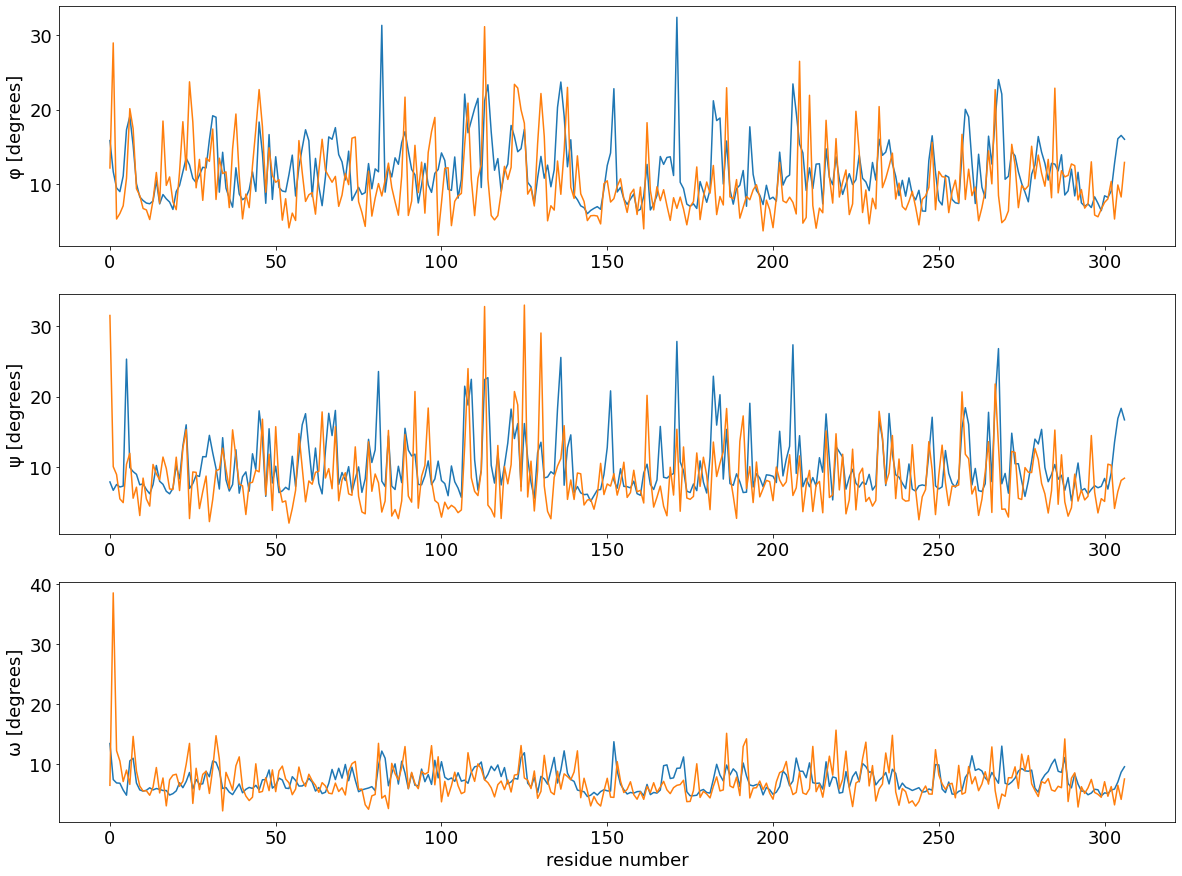

In [101]:
fig = plt.figure(figsize=(20,15))

fig.add_subplot(3, 1, 1)
li = dihedral_std(phi_array1.copy())
plt.plot(list(range(len(li))), li)
li = dihedral_std(phi_array2.copy())
print(np.argsort(li)[::-1][:50])
plt.plot(list(range(len(li))), li)
plt.ylabel(u'\u03c6 [degrees]')

fig.add_subplot(3, 1, 2)
# li = psi_array1.mean(axis=axis)
li = dihedral_std(psi_array1.copy())
plt.plot(list(range(len(li))), li)
# li = psi_array2.mean(axis=axis)
li = dihedral_std(psi_array2.copy())
print(np.argsort(li)[::-1][:50])
plt.plot(list(range(len(li))), li)
plt.ylabel(u'\u03c8 [degrees]')

fig.add_subplot(3, 1, 3)
li = dihedral_std(omega_array1.copy())
plt.plot(list(range(len(li))), li)
li = dihedral_std(omega_array2.copy())
print(np.argsort(li)[::-1][:50])
plt.plot(list(range(len(li))), li)
plt.xlabel("residue number")
plt.ylabel(u'\u03c9 [degrees]')